# Do DL models and training environments have an impact on the energy consumption of computer vision training?

## RQ3.2: Which parameters can help estimate energy consumption?

Author: Santiago del Rey


## Import libraries


In [1]:
import os
import re
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from math import sqrt
from scipy import stats
from tqdm import tqdm
from sklearn.metrics import root_mean_squared_error

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.features.preprocessing import (
    get_duration,
    get_epoch_ends,
    HOURS_TO_SECONDS,
    JOULES_TO_KJOULES,
    KJOULES_TO_JOULES,
    MJOULES_TO_KJOULES,
    MJOULES_TO_JOULES,
)
from src.features.analysis import plot_regime_change, find_stabilizing_point, build_energy_estimation
from src.environment import CONFIGS_DIR, METRICS_DIR, DATA_DIR, FIGURES_DIR

SAVE_FIGS = True
FIGURES_FORMAT = "pdf"
SAVE_FIGS_DIR = FIGURES_DIR / FIGURES_FORMAT

if not SAVE_FIGS_DIR.exists():
    os.makedirs(SAVE_FIGS_DIR)

# Set numpy random seed for reproducibility
rng = np.random.default_rng(seed=2024)

sns.set_theme(style="whitegrid", context="paper", palette="colorblind", color_codes=True, font_scale=1.5)
plt.style.use(CONFIGS_DIR / "figures.mplstyle")

%matplotlib inline

## Utility functions and constants


In [2]:
INDEPENDENT_VARIABLES = [
    "training environment",
    "architecture",
    "dataset",
    "batch size",
    "image size",
    "total ram (GB)",
]
RELEVANT_METRICS = [
    "run_id",
    "start time",
    "training duration (h)",
    "return code",
    "gpu usage (%)",
    "average gpu power (W)",
    "gpu energy (MJ)",
    "max power limit (W)",
    "average ram power (W)",
    "ram energy (MJ)",
    "energy (MJ)",
    "GFLOPs",
    "trained epochs",
    "measured epochs",
    "total seen images",
]

## Load the datasets


In [3]:
aggregated_metrics = pd.read_parquet(
    METRICS_DIR / "processed" / "clean-dl-training-energy-consumption-dataset.gzip",
    columns=INDEPENDENT_VARIABLES + RELEVANT_METRICS,
).sort_values(by=["start time"])

aggregated_metrics.replace(
    {
        "Local Normal User": "Local N",
        "Local ML Engineer": "Local ML",
    },
    inplace=True,
)

aggregated_metrics.head()

,training environment,architecture,dataset,batch size,image size,total ram (GB),run_id,start time,training duration (h),return code,...,average gpu power (W),gpu energy (MJ),max power limit (W),average ram power (W),ram energy (MJ),energy (MJ),GFLOPs,trained epochs,measured epochs,total seen images
0,Cloud,mobilenet_v2,chesslive-occupancy,32,"(128, 128)",16.0,ed5f9d5907ee495fb655e7e90aff1fac,2022-12-05 09:55:44.537,0.735028,0.0,...,156.930408,0.415289,350.0,4.702747,0.012444,0.427733,0.064028,89,86,2919872
1,Cloud,mobilenet_v2,chesslive-occupancy,32,"(128, 128)",16.0,782109dee17a4c399030b0822155591f,2022-12-05 10:47:16.997,0.796192,0.0,...,153.356494,0.439651,350.0,4.813751,0.013798,0.453448,0.064028,93,92,3123584
2,Cloud,mobilenet_v2,chesslive-occupancy,32,"(128, 128)",16.0,b85c1287f4344b7996bffcd15d890d86,2022-12-05 11:41:08.533,0.472226,0.0,...,150.298999,0.255596,350.0,4.828642,0.008209,0.263805,0.064028,56,55,1867360
3,Cloud,mobilenet_v2,chesslive-occupancy,32,"(128, 128)",16.0,5a4800e73d8241b19bb9369dd74295f9,2022-12-05 12:15:34.087,0.634343,0.0,...,156.511394,0.357506,350.0,4.841027,0.011055,0.368561,0.064028,75,74,2512448
4,Cloud,mobilenet_v2,chesslive-occupancy,32,"(128, 128)",16.0,29bb5be7abd140b68c106c87604df9a9,2022-12-05 12:59:41.666,0.662704,0.0,...,149.651426,0.357111,350.0,4.855310,0.011583,0.368695,0.064028,77,76,2580352


In [4]:
metrics = pd.read_parquet(os.path.join(METRICS_DIR, "interim", "dl-training-profiling-dataset.gzip"))
metrics.query("`run_id` in @aggregated_metrics['run_id'].values", inplace=True)
metrics["elapsed_time"] = metrics["elapsed_time"] / np.timedelta64(1, "s")
metrics["epoch"] = metrics["epoch"].astype("int")

metrics.head()

,train_environment,architecture,dataset,run_id,timestamp,gpu_name,gpu_usage,gpu_memory_usage,gpu_total_memory,gpu_memory_used,gpu_power_draw,gpu_max_power,gpu_temperature,cpu_usage,memory_usage,total_memory,memory_power_draw,elapsed_time,creation_time,epoch
0,cloud,inception_v3,caltech101,00131e286bc847e4a0447e0944ba95b6,2023-12-18 20:52:07.470,NVIDIA GeForce RTX 3090,0.0,0.0,24576.0,22724.0,111.0,350.0,48.0,5.000,1810.870972,16.0,0.679077,0.000,20231218T205204,0
1,cloud,inception_v3,caltech101,00131e286bc847e4a0447e0944ba95b6,2023-12-18 20:52:08.471,NVIDIA GeForce RTX 3090,0.0,0.0,24576.0,22724.0,111.0,350.0,48.0,4.167,1814.616943,16.0,0.680481,1.001,20231218T205204,0
2,cloud,inception_v3,caltech101,00131e286bc847e4a0447e0944ba95b6,2023-12-18 20:52:09.474,NVIDIA GeForce RTX 3090,0.0,0.0,24576.0,22724.0,111.0,350.0,48.0,3.679,1849.836060,16.0,0.693689,2.004,20231218T205204,0
3,cloud,inception_v3,caltech101,00131e286bc847e4a0447e0944ba95b6,2023-12-18 20:52:10.475,NVIDIA GeForce RTX 3090,0.0,0.0,24576.0,22724.0,111.0,350.0,48.0,3.679,1852.379028,16.0,0.694642,3.005,20231218T205204,0
4,cloud,inception_v3,caltech101,00131e286bc847e4a0447e0944ba95b6,2023-12-18 20:52:11.476,NVIDIA GeForce RTX 3090,0.0,0.0,24576.0,22724.0,111.0,350.0,48.0,1.242,1854.973022,16.0,0.695615,4.006,20231218T205204,0


## Is epoch duration stable?

First, we compute the duration of each epoch using the end time of the epoch and the start time of the next epoch. Then, we plot the distribution of the duration of the epochs.


In [5]:
epoch_energy_df = pd.read_parquet(METRICS_DIR / "processed" / "clean-dl-epoch-energy-consumption-dataset.gzip")
epoch_energy_df["epoch"] = epoch_energy_df["epoch"].astype("int")
epoch_energy_df.replace(
    {
        "Local Normal User": "Local N",
        "Local ML Engineer": "Local ML",
    },
    inplace=True,
)

In [6]:
epoch_energy_df.head()

,training environment,architecture,dataset,run_id,epoch,duration (s),batch size,image size,total ram (GB),mean gpu power (W),gpu energy (kJ),mean ram power (W),ram energy (kJ),total energy (kJ)
0,Cloud,inception_v3,caltech101,00131e286bc847e4a0447e0944ba95b6,0,23.369797,64,"(75, 75)",16.0,117.208333,2.697042,1.150193,0.026040,2.723082
1,Cloud,inception_v3,caltech101,00131e286bc847e4a0447e0944ba95b6,1,2.824384,64,"(75, 75)",16.0,164.000000,0.496187,2.515244,0.007558,0.503744
2,Cloud,inception_v3,caltech101,00131e286bc847e4a0447e0944ba95b6,2,2.274989,64,"(75, 75)",16.0,161.000000,0.311956,2.517369,0.005042,0.316998
3,Cloud,inception_v3,caltech101,00131e286bc847e4a0447e0944ba95b6,3,2.341524,64,"(75, 75)",16.0,145.666667,0.289789,2.517365,0.005040,0.294829
4,Cloud,inception_v3,caltech101,00131e286bc847e4a0447e0944ba95b6,4,2.290775,64,"(75, 75)",16.0,146.750000,0.438083,2.517358,0.007562,0.445645


From the histogram, we can have an intuition that the epoch duration is generally stable, whithin a small margin.


### Histogram of epoch duration for the Caltech101 dataset in the Cloud


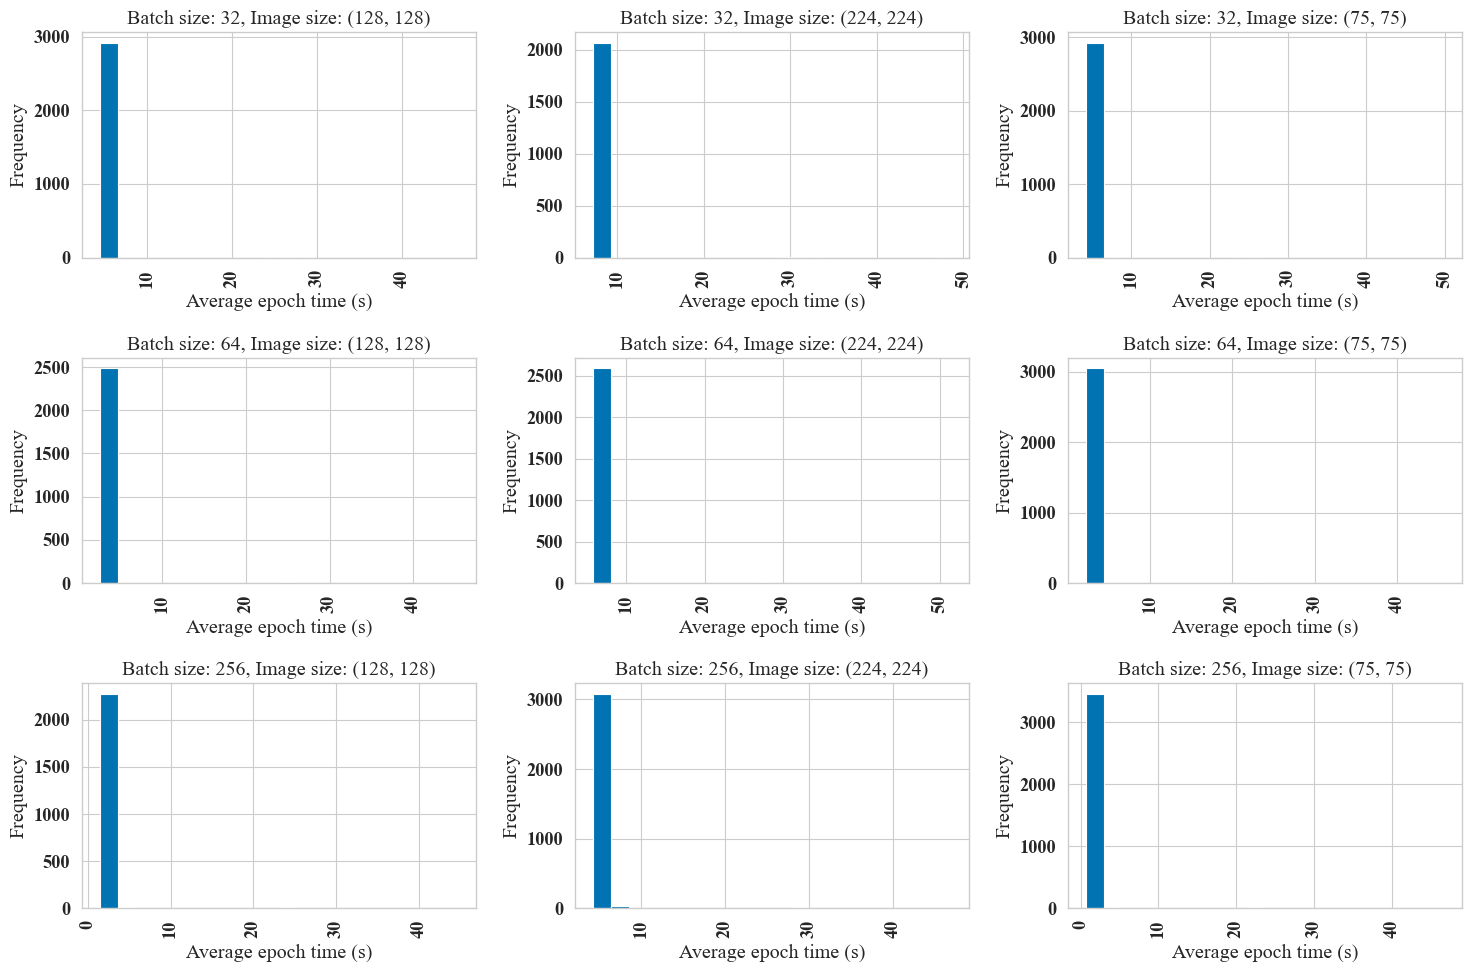

In [7]:
hist = epoch_energy_df.query("`training environment` == 'Cloud' and `dataset` == 'caltech101'").hist(
    column="duration (s)", by=["dataset", "batch size", "image size"], bins=20, figsize=(15, 10), layout=(3, 3)
)
for ax in hist.flatten():
    old_title = ax.get_title()
    if old_title == "":
        continue
    # ax.set_xlabel("Log$_{10}$(Average epoch time) (s)")
    ax.set_xlabel("Average epoch time (s)")
    ax.set_ylabel("Frequency")
    _, batch, input_size0, input_size1 = old_title.split(", ")
    ax.set_title(f"Batch size: {batch}, Image size: {input_size0}, {input_size1[:-1]}")

#### Histogram of epoch duration for the Caltech101 dataset in the Local ML Engineer environment


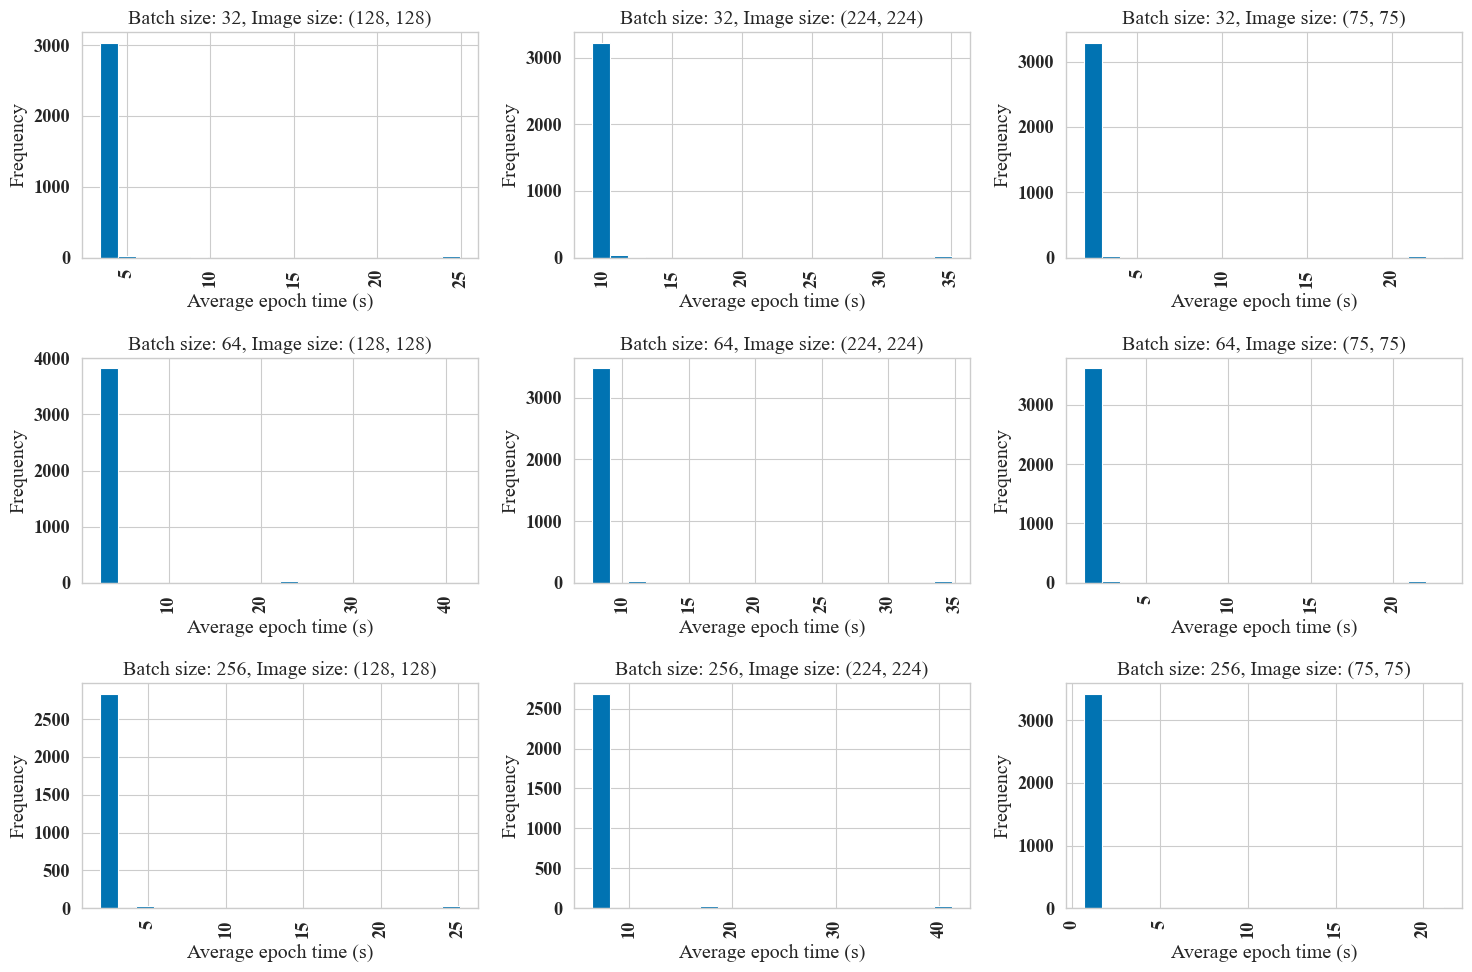

In [8]:
hist = epoch_energy_df.query("`training environment` == 'Local ML' and `dataset` == 'caltech101'").hist(
    column="duration (s)", by=["dataset", "batch size", "image size"], bins=20, figsize=(15, 10), layout=(3, 3)
)
for ax in hist.flatten():
    old_title = ax.get_title()
    if old_title == "":
        continue
    # ax.set_xlabel("Log$_{10}$(Average epoch time) (s)")
    ax.set_xlabel("Average epoch time (s)")
    ax.set_ylabel("Frequency")
    _, batch, input_size0, input_size1 = old_title.split(", ")
    ax.set_title(f"Batch size: {batch}, Image size: {input_size0}, {input_size1[:-1]}")

### Histogram of epoch duration for the Stanford Dogs dataset in the Cloud


/tmp/ipykernel_22059/870585577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_data["label"] = "Batch: " + hist_data["batch size"].astype(str) + ", Input: " + hist_data["image size"].astype(str)


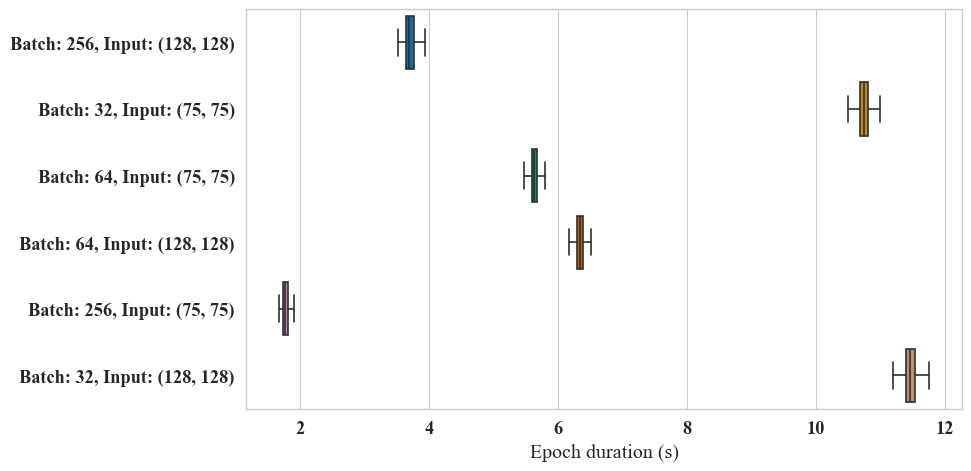

In [9]:
hist_data = epoch_energy_df.query("`training environment` == 'Cloud' and `dataset` == 'stanford_dogs' and epoch >= 10")
hist_data["label"] = "Batch: " + hist_data["batch size"].astype(str) + ", Input: " + hist_data["image size"].astype(str)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot(data=hist_data, y="label", x="duration (s)", ax=ax, showfliers=False)
ax.set_ylabel("")
ax.set_xlabel("Epoch duration (s)")

if SAVE_FIGS:
    plt.savefig(SAVE_FIGS_DIR / f"epoch-time-boxplot-cloud-stanford-dogs.{FIGURES_FORMAT}", format=FIGURES_FORMAT)

#### Histogram of epoch duration for the Stanford Dogs dataset in the Local ML Engineer environment


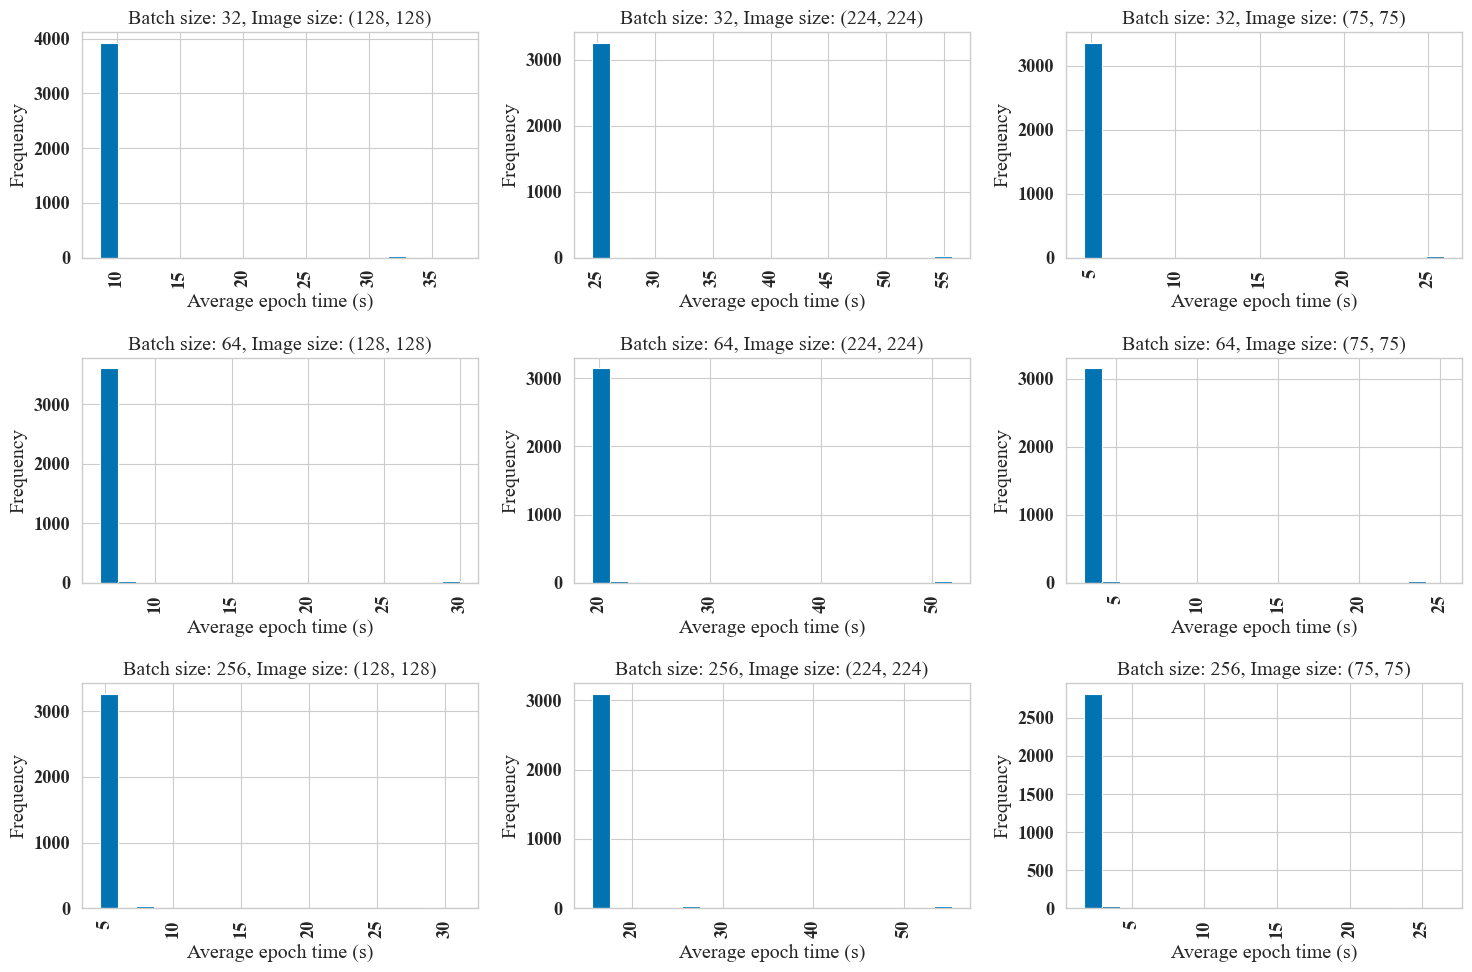

In [10]:
hist = epoch_energy_df.query("`training environment` == 'Local ML' and `dataset` == 'stanford_dogs'").hist(
    column="duration (s)", by=["dataset", "batch size", "image size"], bins=20, figsize=(15, 10), layout=(3, 3)
)
for ax in hist.flatten():
    old_title = ax.get_title()
    if old_title == "":
        continue
    # ax.set_xlabel("Log$_{10}$(Average epoch time) (s)")
    ax.set_xlabel("Average epoch time (s)")
    ax.set_ylabel("Frequency")
    _, batch, input_size0, input_size1 = old_title.split(", ")
    ax.set_title(f"Batch size: {batch}, Image size: {input_size0}, {input_size1[:-1]}")

If we look at the at the actual values. We see that most of the maximum differences are below 5 seconds when excluding the first epoch. Moreover, independently of the dataset, batch size and image size, 75% of the epochs have a duration difference below 1 second.


In [11]:
epoch_energy_df.query("`dataset` != 'chesslive-occupancy' and `epoch` > 0").groupby(
    ["training environment", "dataset", "batch size", "image size"]
)["duration (s)"].agg(np.ptp)

training environment  dataset        batch size  image size
Cloud                 caltech101     32          (128, 128)     2.801594
                                                 (224, 224)     1.705841
                                                 (75, 75)       2.845826
                                     64          (128, 128)     1.248249
                                                 (224, 224)     2.523697
                                                 (75, 75)       5.638442
                                     256         (128, 128)     2.466318
                                                 (224, 224)     4.483317
                                                 (75, 75)       2.542804
                      stanford_dogs  32          (128, 128)     2.292980
                                                 (75, 75)       2.116085
                                     64          (128, 128)     1.233051
                                                 (75, 75)       

In [12]:
epoch_energy_df.query("`dataset` != 'chesslive-occupancy'").groupby(
    ["training environment", "dataset", "batch size", "image size"]
)["duration (s)"].describe()

count       mean  \
training environment dataset       batch size image size                       
Cloud                caltech101    32         (128, 128)   2937.0   4.786936   
                                              (224, 224)   2079.0   7.586505   
                                              (75, 75)     2947.0   4.614621   
                                   64         (128, 128)   2504.0   2.874291   
                                              (224, 224)   2612.0   6.114621   
                                              (75, 75)     3069.0   2.552822   
                                   256        (128, 128)   2309.0   1.847423   
                                              (224, 224)   3146.0   4.701526   
                                              (75, 75)     3509.0   0.987720   
                     stanford_dogs 32         (128, 128)   2497.0  11.731451   
                                              (75, 75)     2855.0  10.976831   
                                   64         (128, 128)   2988.0   6.647584   
                                              (75, 75)     2189.0   5.889276   
                                   256        (128, 128)  12958.0   4.046810   
                                              (75, 75)     2541.0   2.103285   
Local ML             caltech101    32         (128, 128)   3086.0   3.829164   
                                              (224, 224)   3279.0   9.935656   
                                              (75, 75)     3341.0   2.251973   
                                   64         (128, 128)   3853.0   2.896171   
                                              (224, 224)   3527.0   8.236864   
                                              (75, 75)     3672.0   1.533245   
                                   256        (128, 128)   2889.0   2.289293   
                                              (224, 224)   2736.0   6.902881   
                                              (75, 75)     3453.0   0.875960   
                     stanford_dogs 32         (128, 128)   3949.0   9.301469   
                                              (224, 224)   3279.0  25.307926   
                                              (75, 75)     3383.0   5.218137   
                                   64         (128, 128)   3659.0   6.776988   
                                              (224, 224)   3201.0  20.212565   
                                              (75, 75)     3206.0   3.420310   
                                   256        (128, 128)   3327.0   4.990702   
                                              (224, 224)   3154.0  16.209702   
                                              (75, 75)     2868.0   2.017643   

                                                               std        min  \
training environment dataset       batch size image size                        
Cloud                caltech101    32         (128, 128)  2.014445   4.377414   
                                              (224, 224)  2.295180   7.193695   
                                              (75, 75)    2.173271   4.181325   
                                   64         (128, 128)  2.473601   2.524662   
                                              (224, 224)  2.576414   5.745983   
                                              (75, 75)    2.639670   2.187022   
                                   256        (128, 128)  2.861852   1.431562   
                                              (224, 224)  2.646141   4.230066   
                                              (75, 75)    2.176068   0.628560   
                     stanford_dogs 32         (128, 128)  3.043429  10.829132   
                                              (75, 75)    2.678839  10.271094   
                                   64         (128, 128)  3.414375   6.145099   
                                              (75, 75)    2.683218   5.434116   
                                   256      

## Power profile analysis


### When does power consumption stabilize?


To detect when the power consumption stabilizes, we will apply semanting segmentation on the power profiles of each run.
To this end, we will compute the Matrix Profile (MP) of each run setting the window size $m = 10$.

We will use the [stumpy](https://stumpy.readthedocs.io/en/latest/) library to compute the MP and to apply semantic segmentation.

First, we compute the MP of each run. Then, we use the MP to compute the corrected arc curve (CAC).
From the CAC, we select the point with the lowest value as the point where there is a change in the power consumption regime.
We will call this point the _stabilizing point_.
We will use this point to compute the time it took for the power consumption to stabilize and which epoch it corresponds to.

For this analysis we will use the runs from the Cloud enviroment using the InceptionV3 model, since are the ones where we have the actual epoch duration.


In [13]:
m = 10
L = m
if not os.path.exists(DATA_DIR / "analysis" / "processed" / "regimes.gzip") or not os.path.exists(
    DATA_DIR / "analysis" / "processed" / "cloud_inception_mps.pkl"
):
    regimes_df, profiles = find_stabilizing_point(aggregated_metrics["run_id"].unique(), metrics, m, L, save=True)
    regimes_df["stabilizing epoch"] = regimes_df["stabilizing epoch"].astype(np.uint8)
else:
    regimes_df = pd.read_parquet(DATA_DIR / "analysis" / "processed" / "regimes.gzip")
    regimes_df["stabilizing epoch"] = regimes_df["stabilizing epoch"].astype(np.uint8)
    with open(DATA_DIR / "analysis" / "processed" / "cloud_inception_mps.pkl", "rb") as f:
        profiles = pickle.load(f)

In [14]:
regimes_df = regimes_df.merge(
    aggregated_metrics[INDEPENDENT_VARIABLES + ["run_id"]], on="run_id", how="inner"
)  # Add independent variables to group results by batch size and image size
regimes_df.groupby(["dataset", "batch size", "image size"]).describe()

elapsed time                \
                                                 count          mean   
dataset             batch size image size                              
caltech101          32         (128, 128)         50.0  3.523076e+10   
                               (224, 224)         41.0  3.195317e+10   
                               (75, 75)           49.0  3.171790e+10   
                    64         (128, 128)         51.0  3.230265e+10   
                               (224, 224)         47.0  3.187615e+10   
                               (75, 75)           53.0  3.654306e+10   
                    256        (128, 128)         46.0  3.507385e+10   
                               (224, 224)         51.0  3.810396e+10   
                               (75, 75)           57.0  2.608595e+10   
chesslive-occupancy 32         (128, 128)        324.0  8.097318e+11   
stanford_dogs       32         (128, 128)         50.0  3.631474e+10   
                               (224, 224)         25.0  8.482898e+11   
                               (75, 75)           49.0  1.039675e+11   
                    64         (128, 128)         52.0  3.615063e+10   
                               (224, 224)         26.0  2.372440e+11   
                               (75, 75)           46.0  3.304711e+10   
                    256        (128, 128)        136.0  3.574754e+10   
                               (224, 224)         26.0  5.026885e+10   
                               (75, 75)           46.0  3.413554e+10   

                                                                       \
                                                    std           min   
dataset             batch size image size                               
caltech101          32         (128, 128)  3.275135e+10  3.003200e+10   
                               (224, 224)  3.016276e+09  3.003200e+10   
                               (75, 75)    5.134526e+09  3.003200e+10   
                    64         (128, 128)  5.667482e+09  3.003100e+10   
                               (224, 224)  4.551007e+09  3.003100e+10   
                               (75, 75)    1.503570e+10  3.003300e+10   
                    256        (128, 128)  1.158561e+10  3.003100e+10   
                               (224, 224)  2.600132e+10  3.003000e+10   
                               (75, 75)    9.733723e+09  1.500900e+10   
chesslive-occupancy 32         (128, 128)  2.097072e+12  3.203300e+10   
stanford_dogs       32         (128, 128)  9.098878e+09  3.003600e+10   
                               (224, 224)  1.311836e+12  3.004400e+10   
                               (75, 75)    2.528828e+11  3.003400e+10   
                    64         (128, 128)  9.542520e+09  3.004400e+10   
                               (224, 224)  6.422493e+11  3.004400e+10   
                               (75, 75)    4.109225e+09  3.004300e+10   
                    256        (128, 128)  9.308825e+09  2.205800e+10   
                               (224, 224)  8.356279e+09  3.005200e+10   
                               (75, 75)    7.944581e+09  3.003300e+10   

                                                                       \
                                                    25%           50%   
dataset             batch size image size                               
caltech101          32         (128, 128)  3.003500e+10  3.004400e+10   
                               (224, 224)  3.003700e+10  3.105000e+10   
                               (75, 75)    3.003800e+10  3.004600e+10   
                    64         (128, 128)  3.003900e+10  3.004800e+10   
                               (224, 224)  3.003950e+10  3.004800e+10   
                               (75, 75)    3.004300e+10  3.004700e+10   
                    256        (128, 128)  3.004475e+10  3.004900e+10   
                               (224, 224)  3.003300e+10  3.004800e+10   
                               (75, 75)    2.10

Looking at the histogram of the time it took for the power consumption to stabilize, we can see that over 60% of the runs stabilized in less than a minute from the start of the run.


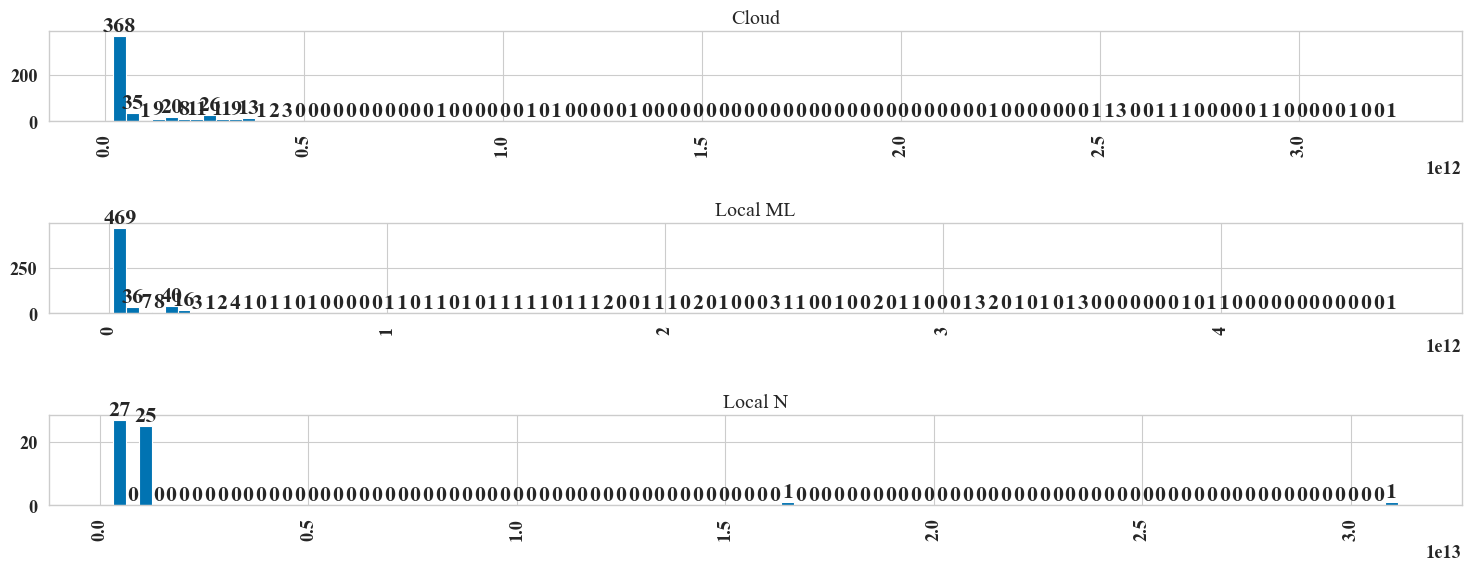

In [15]:
axs = regimes_df.hist(column="elapsed time", bins=100, figsize=(15, 6), by="training environment", layout=(3, 1))
for ax in axs.flatten():
    ax.bar_label(ax.containers[0], fmt="%d")
    training_env = ax.get_title()
    stop = regimes_df.query("`training environment` == @training_env")["elapsed time"].max() + 5

if SAVE_FIGS:
    plt.savefig(SAVE_FIGS_DIR / f"elapsed-time-histograms.{FIGURES_FORMAT}", format=FIGURES_FORMAT)

Although the elapsed time offers an interesting view in the time it takes for the power consumption to stabilize, it is not reliable to compare runs with different hyperparameters like batch size and image size.

If we look at the epoch where the power consumption stabilized, we can see that more than 90% of the runs stabilized after the fourth epoch.
In fact, if we visually inspect those runs that stabilized after the fourth epoch, we can see there are a couple of false negatives in the the runs that stabilized during epoch 102 and 121.

Based on this results, we will assume that the power consumption stabilizes after the fourth epoch in general.


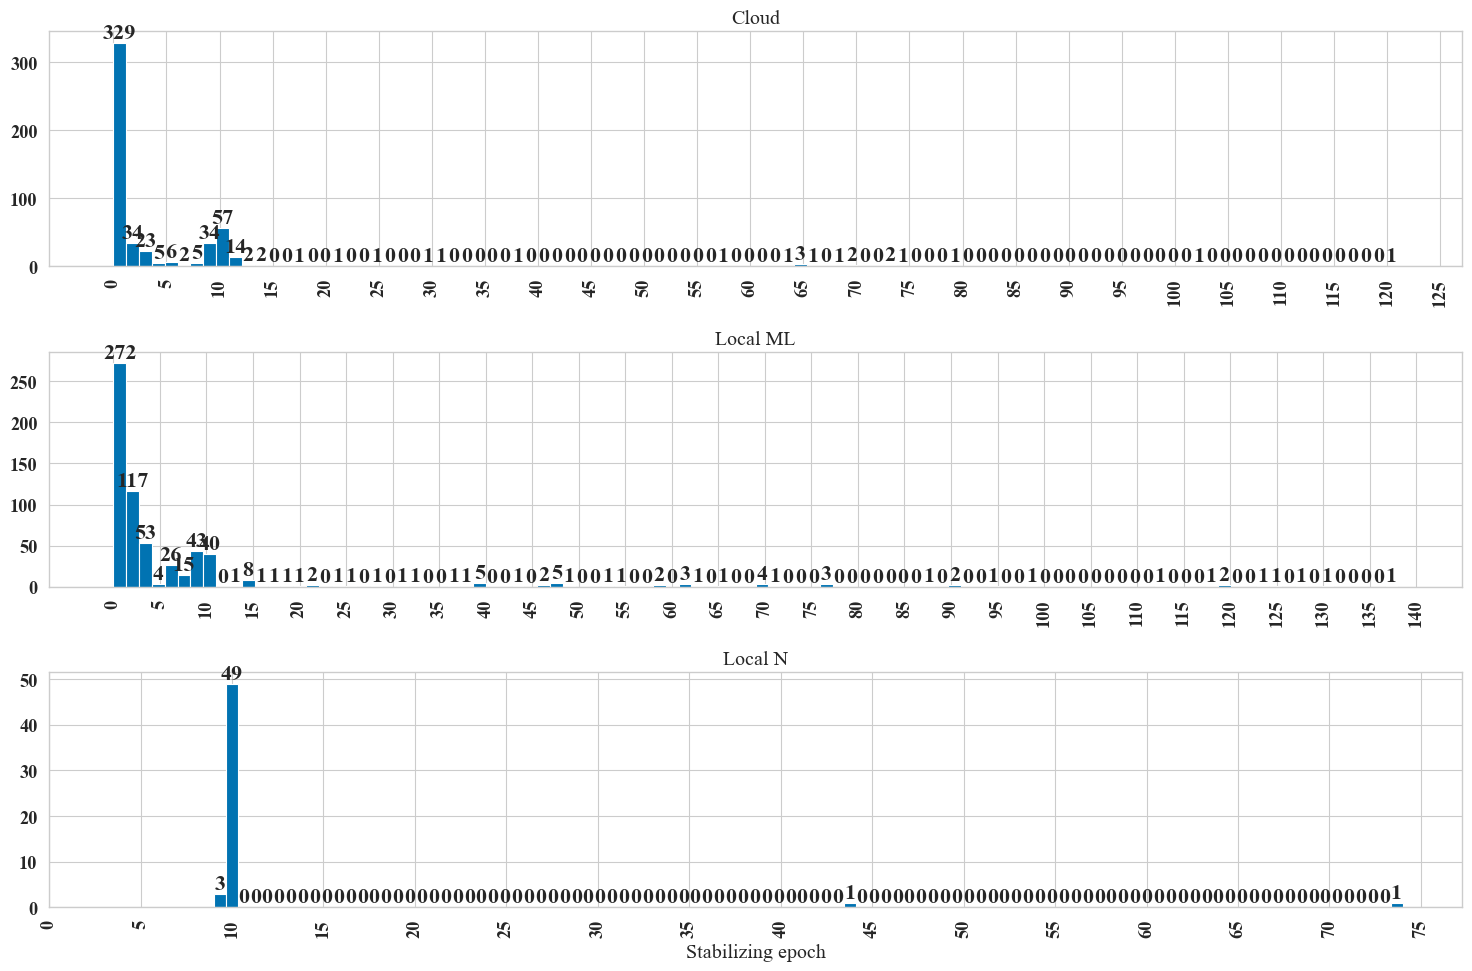

In [16]:
axs = regimes_df.hist(column="stabilizing epoch", bins=100, figsize=(15, 10), by="training environment", layout=(3, 1))
for ax in axs.flatten():
    ax.bar_label(ax.containers[0], fmt="%d")
    training_env = ax.get_title()
    stop = regimes_df.query("`training environment` == @training_env")["stabilizing epoch"].max() + 5
    ax.set_xticks(np.arange(0, stop, 5))

axs[-1].set_xlabel("Stabilizing epoch")

if SAVE_FIGS:
    plt.savefig(SAVE_FIGS_DIR / f"stabilizing-epoch-histograms.{FIGURES_FORMAT}", format=FIGURES_FORMAT)

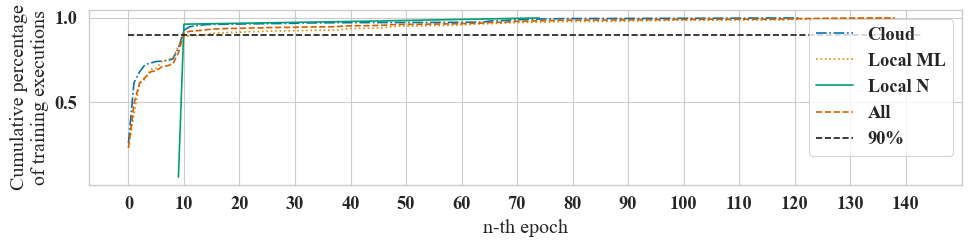

In [17]:
_, ax = plt.subplots(figsize=(10, 2.75))

linestyles = {
    "Local N": "solid",
    "Local ML": "dotted",
    "Cloud": "dashdot",
}

for training_env in regimes_df["training environment"].unique():
    regimes_df.query("`training environment` == @training_env")["stabilizing epoch"].value_counts(
        normalize=True
    ).sort_index().cumsum().plot(
        label=training_env,
        ax=ax,
        linestyle=linestyles[training_env],
    )
regimes_df["stabilizing epoch"].value_counts(normalize=True).sort_index().cumsum().plot(
    label="All", ax=ax, linestyle="dashed"
)
ax.hlines(0.9, 0, regimes_df["stabilizing epoch"].max() + 5, colors="k", linestyles="dashed", label="90%")
# ax.set_title("Accumulated percentage of runs that stabilize after the n-th epoch")
ax.set_ylabel("Cumulative percentage\nof training executions")
ax.set_xlabel("n-th epoch")
ax.set_xticks(np.arange(0, regimes_df["stabilizing epoch"].max() + 5, 10))
ax.legend()

if SAVE_FIGS:
    plt.savefig(SAVE_FIGS_DIR / f"stabilizing-epoch-cumulative-distribution.{FIGURES_FORMAT}", format=FIGURES_FORMAT)

In [18]:
def plot_regime_change_example(stabilizing_epoch):
    example_run = regimes_df.query("`stabilizing epoch` == @stabilizing_epoch")["run_id"].sample(1).iloc[0]
    run = metrics.loc[metrics["run_id"] == example_run]
    epoch_ends = get_epoch_ends(run.iloc[0])
    regime_change = profiles[example_run]["regime_locations"][0]
    cac = profiles[example_run]["cac"]
    plot_regime_change(run, epoch_ends, cac, regime_change, stabilizing_epoch)

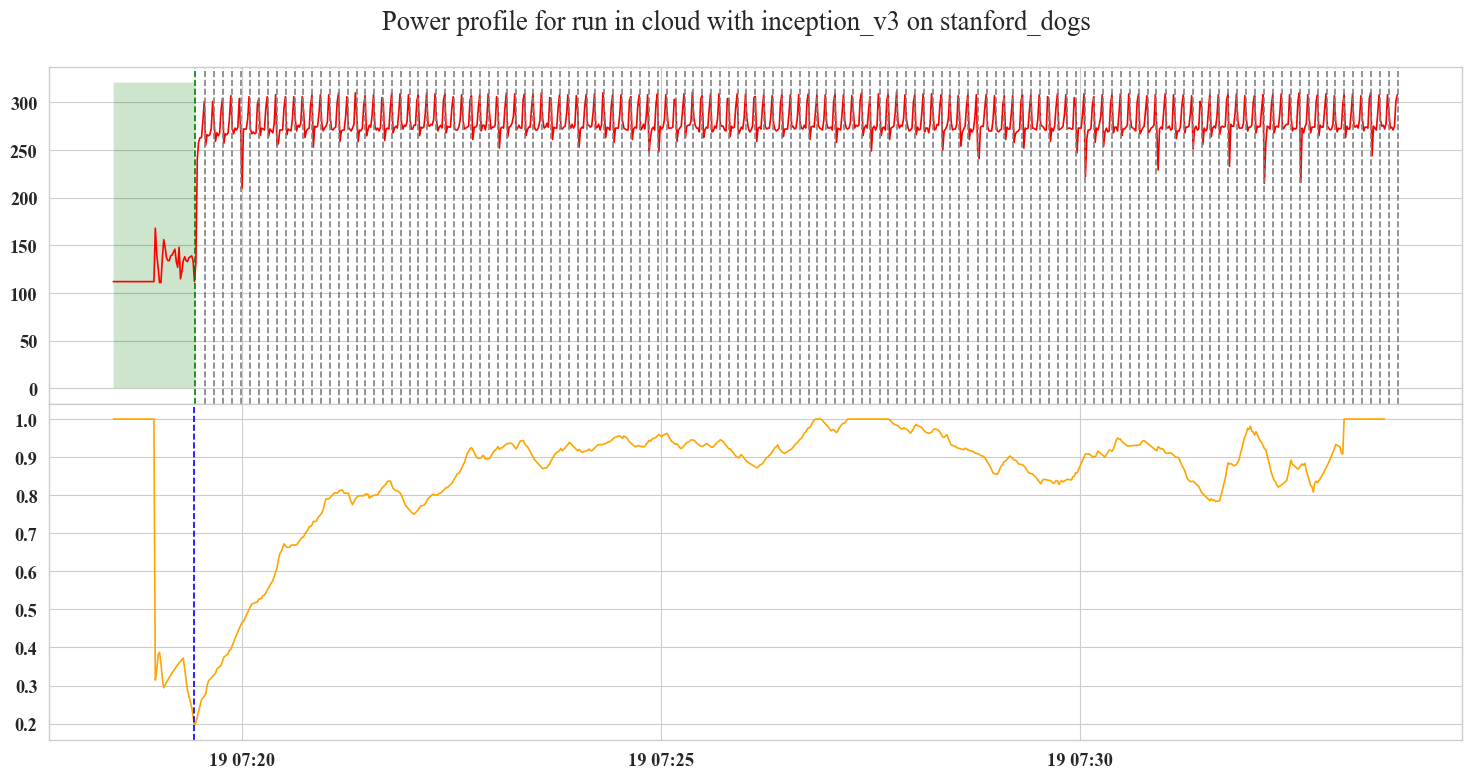

In [19]:
plot_regime_change_example(0)

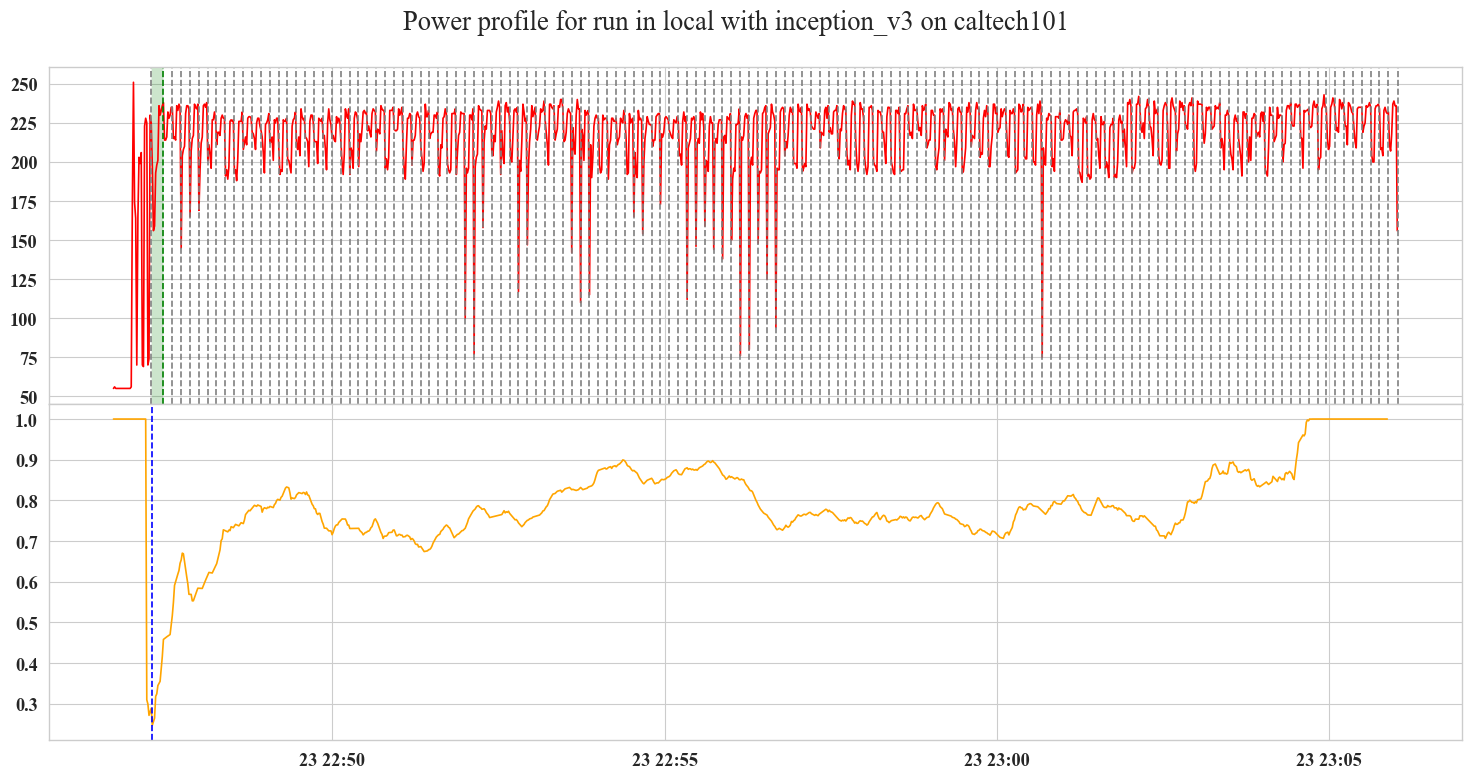

In [20]:
plot_regime_change_example(1)

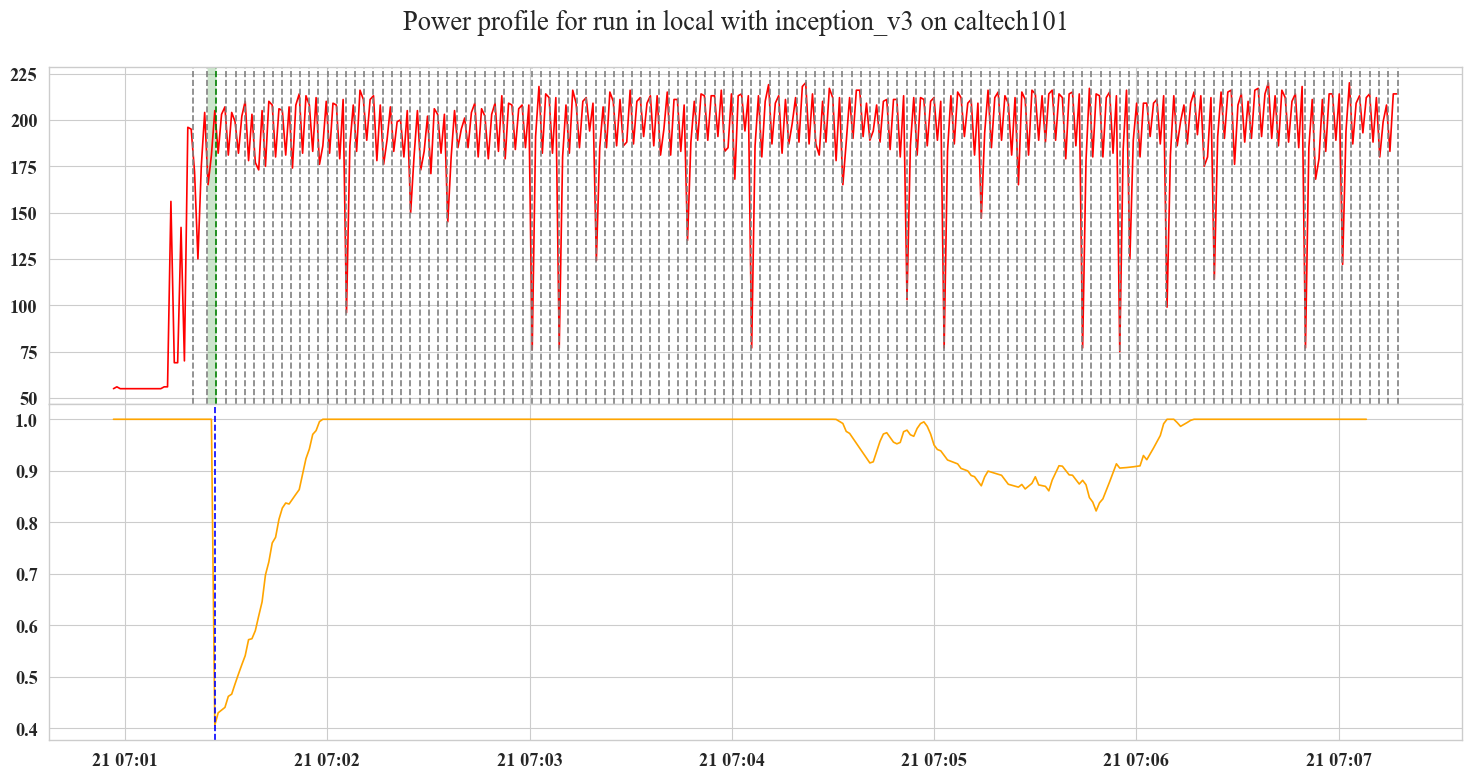

In [21]:
plot_regime_change_example(2)

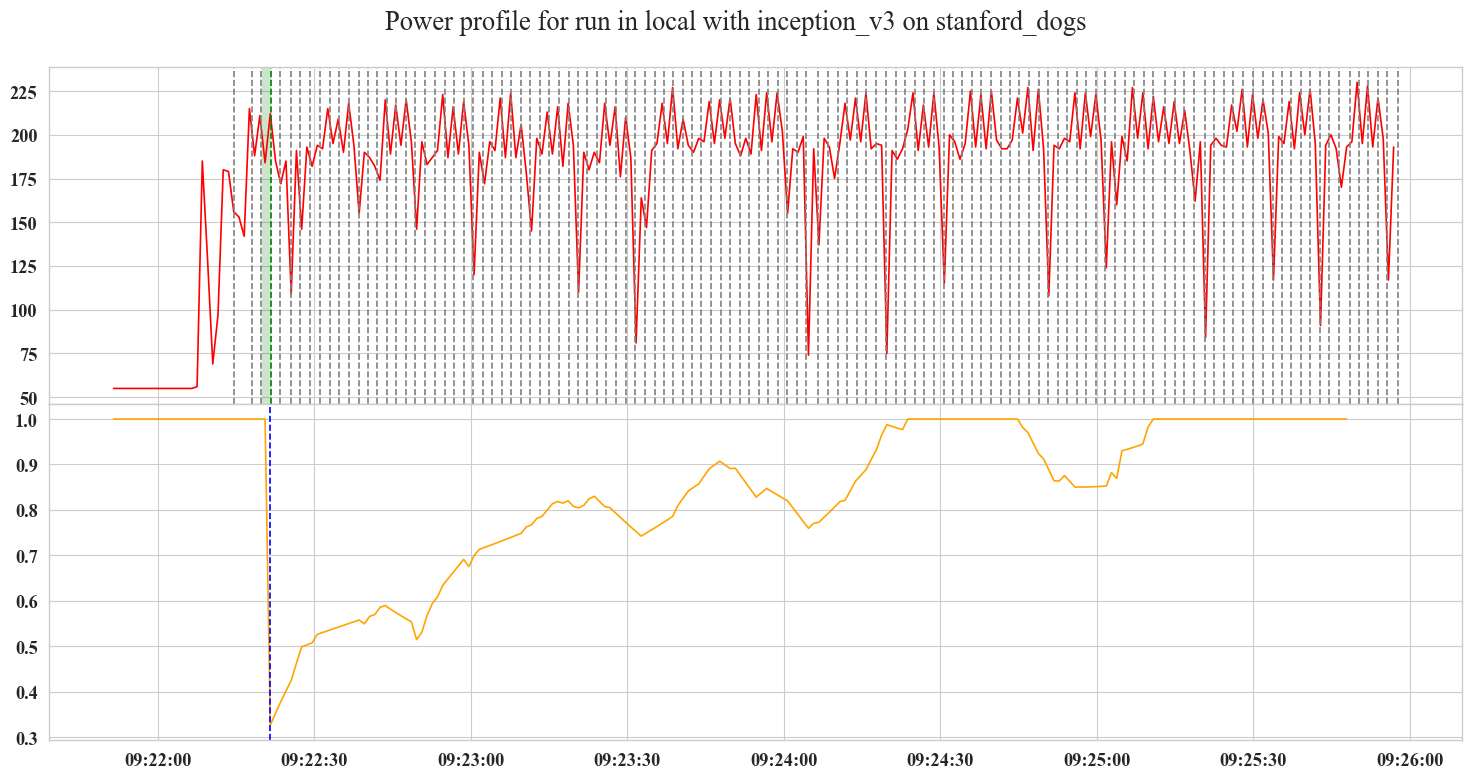

In [22]:
plot_regime_change_example(3)

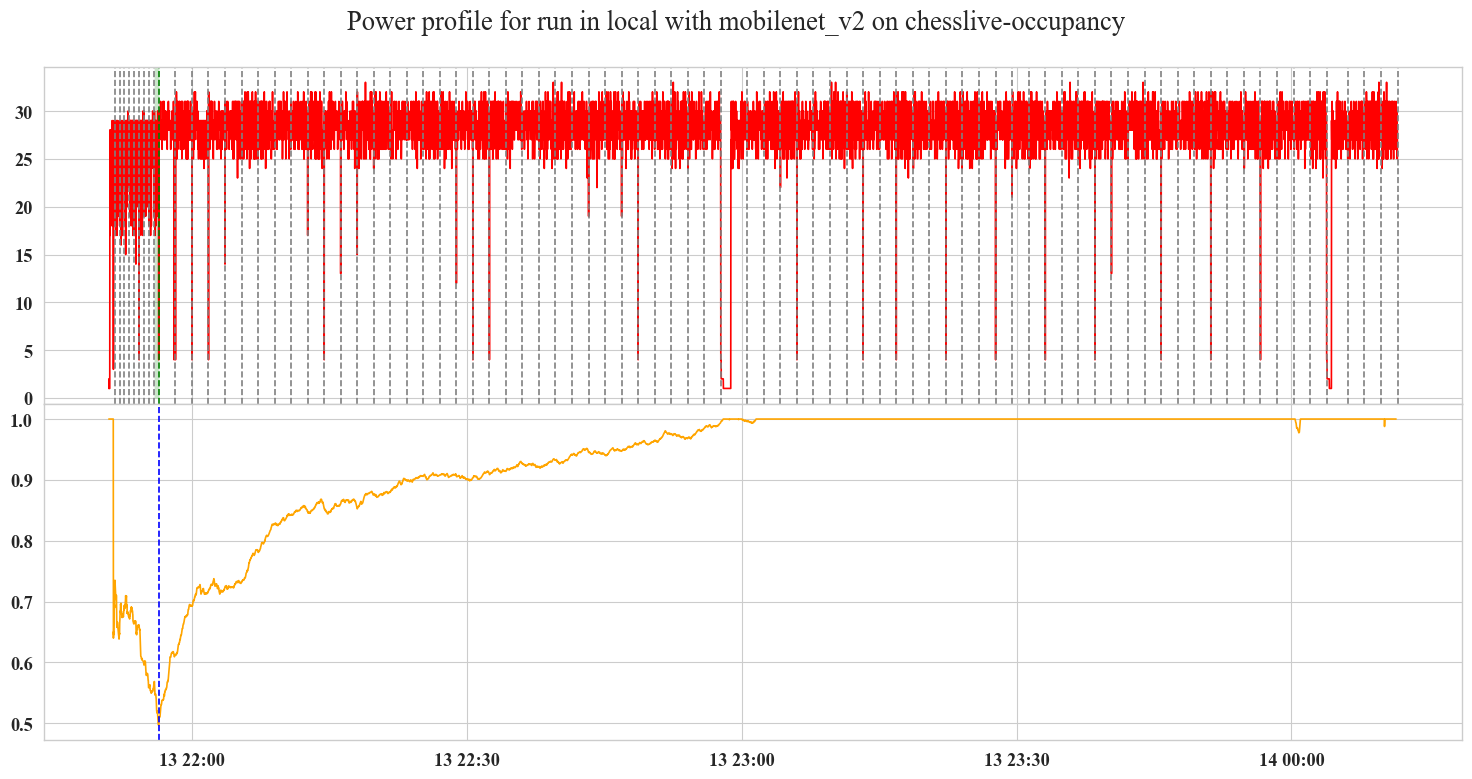

In [23]:
plot_regime_change_example(9)

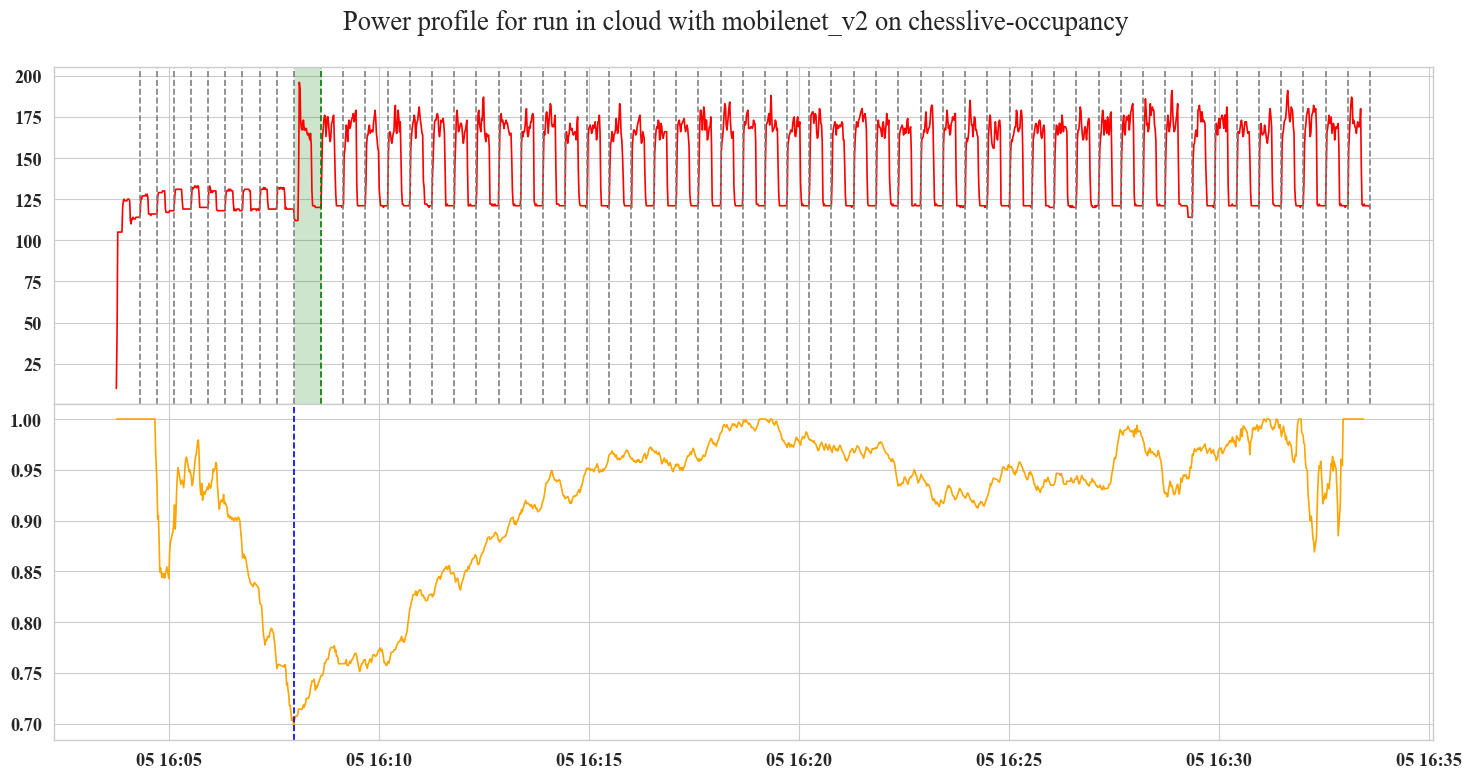

In [24]:
plot_regime_change_example(10)

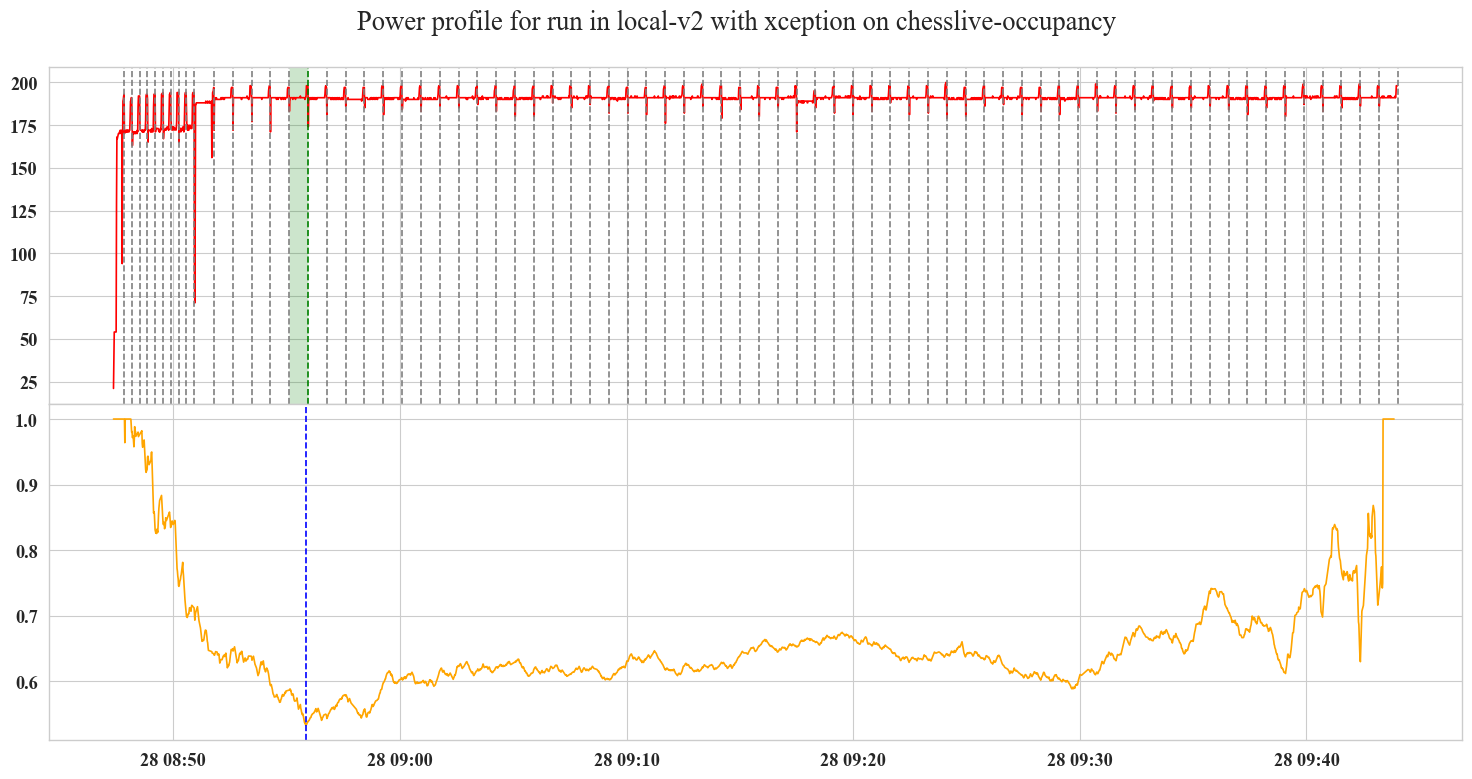

In [25]:
plot_regime_change_example(15)

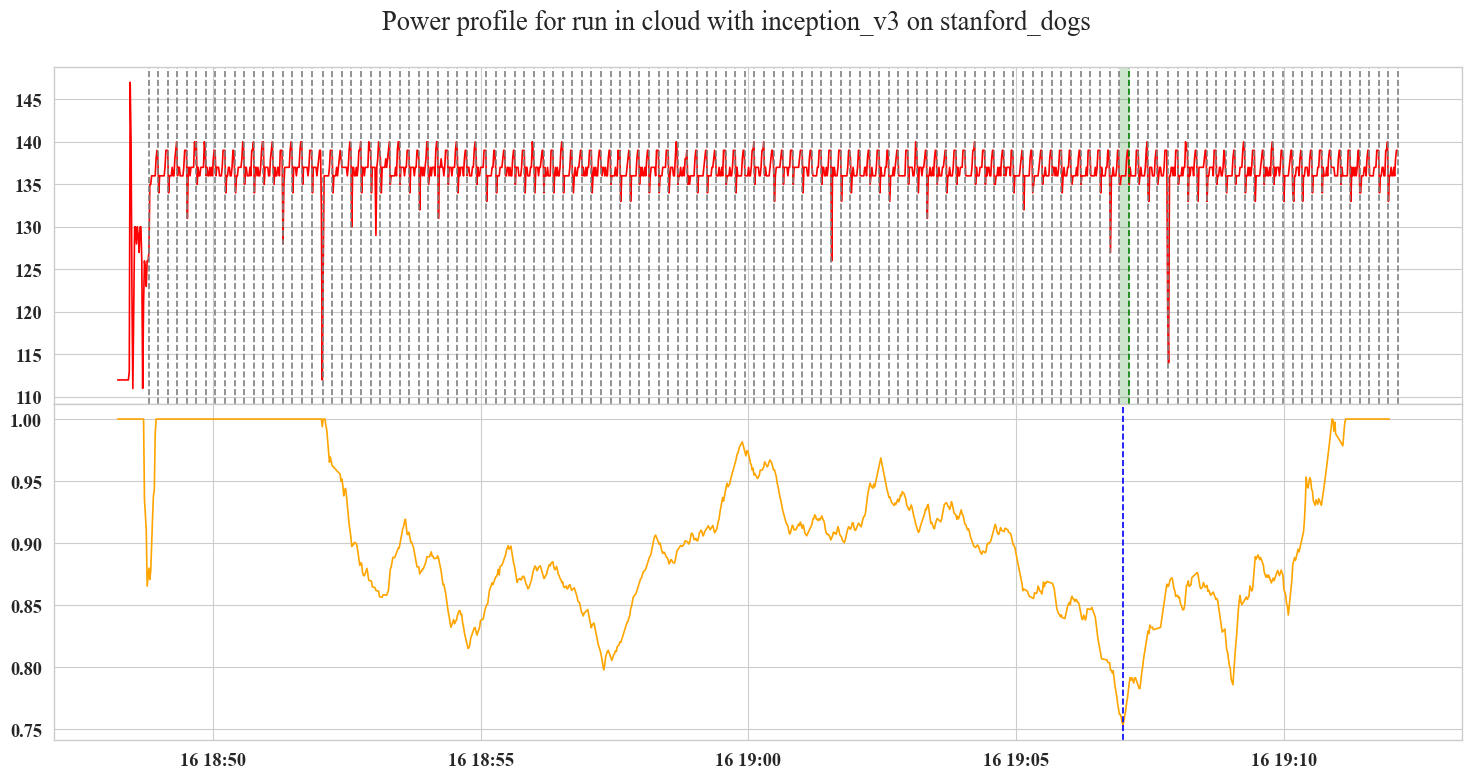

In [26]:
plot_regime_change_example(102)

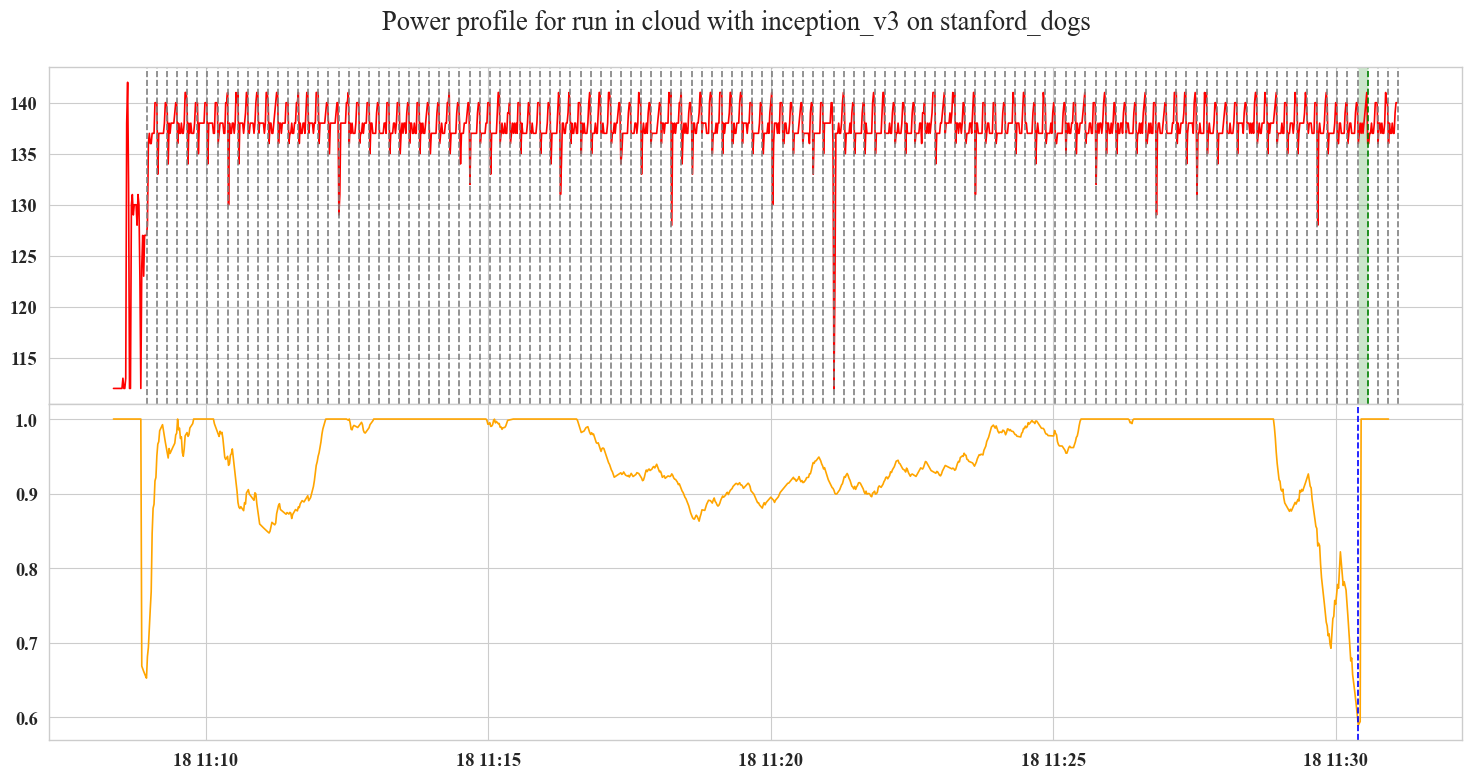

In [27]:
plot_regime_change_example(121)

#### Can we accurately estimate the energy consumption of a run based on some initial epochs?

In the previous section, we saw that the power consumption usually stabilizes after the first ten epochs.
Here we will try to estimate the energy consumption of a run based on the power consumption of a few epochs after the stabilizing point.


In [28]:
stabilizing_epoch = 10

if not os.path.exists(DATA_DIR / "analysis" / "processed" / "mean_power_draw_by_window.pkl"):
    groups = metrics.groupby("run_id")
    mean_power_draw = {
        "run_id": [],
        "window size": [],
        "mean gpu power draw": [],
        "mean ram power draw": [],
        "energy (J)": [],
    }
    for run_id, group in tqdm(groups, total=len(groups)):
        n_epochs = group.query("`epoch` >= @stabilizing_epoch")["epoch"].nunique()
        for window_size, step in enumerate(np.arange(n_epochs), start=1):
            data = group.query("`epoch` >= @stabilizing_epoch and `epoch` <= (@stabilizing_epoch + @step)")
            mean_gpu_power = data["gpu_power_draw"].mean()
            mean_ram_power = data["memory_power_draw"].mean()

            epoch_data = epoch_energy_df.query(
                "`run_id` == @run_id and `epoch` >= @stabilizing_epoch and `epoch` <= (@stabilizing_epoch + @step)"
            )
            energy = epoch_data["total energy (kJ)"].sum() * KJOULES_TO_JOULES

            mean_power_draw["run_id"].append(run_id)
            mean_power_draw["window size"].append(window_size)
            mean_power_draw["mean gpu power draw"].append(mean_gpu_power)
            mean_power_draw["mean ram power draw"].append(mean_ram_power)
            mean_power_draw["energy (J)"].append(energy)

    with open(DATA_DIR / "analysis" / "processed" / "mean_power_draw_by_window.pkl", "wb") as f:
        pickle.dump(mean_power_draw, f)
else:
    with open(DATA_DIR / "analysis" / "processed" / "mean_power_draw_by_window.pkl", "rb") as f:
        mean_power_draw = pickle.load(f)

In [29]:
energy_estimation_from_first_epochs = build_energy_estimation(mean_power_draw, stabilizing_epoch)
energy_estimation_from_first_epochs.head()

,run_id,window size,mean gpu power draw,mean ram power draw,energy (J),training environment,architecture,dataset,training duration (h),mean gpu power (W),...,total ram (GB),total energy (kJ),estimated energy (kJ) (online power-based),estimated total energy (kJ) (online power-based),estimated energy (kJ) (online epoch-energy-based),estimated total energy (kJ) (online epoch-energy-based),estimated energy (kJ) (GA),estimated total energy (kJ) (GA),estimated energy (kJ) (MLCO2),estimated total energy (kJ) (MLCO2)
0,00131e286bc847e4a0447e0944ba95b6,1,146.500000,2.517322,299.984696,cloud,inception_v3,caltech101,0.073999,146.966292,...,16.0,45.911829,39.697470,46.411594,34.798225,40.730960,30.683636,33.636229,93.23825,109.00785
1,00131e286bc847e4a0447e0944ba95b6,2,146.000000,2.517340,597.966445,cloud,inception_v3,caltech101,0.073999,146.966292,...,16.0,45.911829,39.564277,46.255874,34.682054,40.614789,30.683636,33.636229,93.23825,109.00785
2,00131e286bc847e4a0447e0944ba95b6,3,145.571429,2.517344,1038.102070,cloud,inception_v3,caltech101,0.073999,146.966292,...,16.0,45.911829,39.450109,46.122396,40.139947,46.072682,30.683636,33.636229,93.23825,109.00785
3,00131e286bc847e4a0447e0944ba95b6,4,145.777778,2.517344,1338.086813,cloud,inception_v3,caltech101,0.073999,146.966292,...,16.0,45.911829,39.505079,46.186664,38.804518,44.737253,30.683636,33.636229,93.23825,109.00785
4,00131e286bc847e4a0447e0944ba95b6,5,146.333333,2.517343,1788.389919,cloud,inception_v3,caltech101,0.073999,146.966292,...,16.0,45.911829,39.653076,46.359692,41.490646,47.423381,30.683636,33.636229,93.23825,109.00785


In the following figure, we can see how the Root Mean Squared Error (RMSE) decreases as we increase the number of epochs used to estimate the energy consumption. This is to be expected since the more epochs we use, the more accurate the power consumption estimation will be.
However, the relevant point here is that with only 1 epoch after the stabilizing point, we can estimate the energy consumption with an RMSE of less than 0.01.


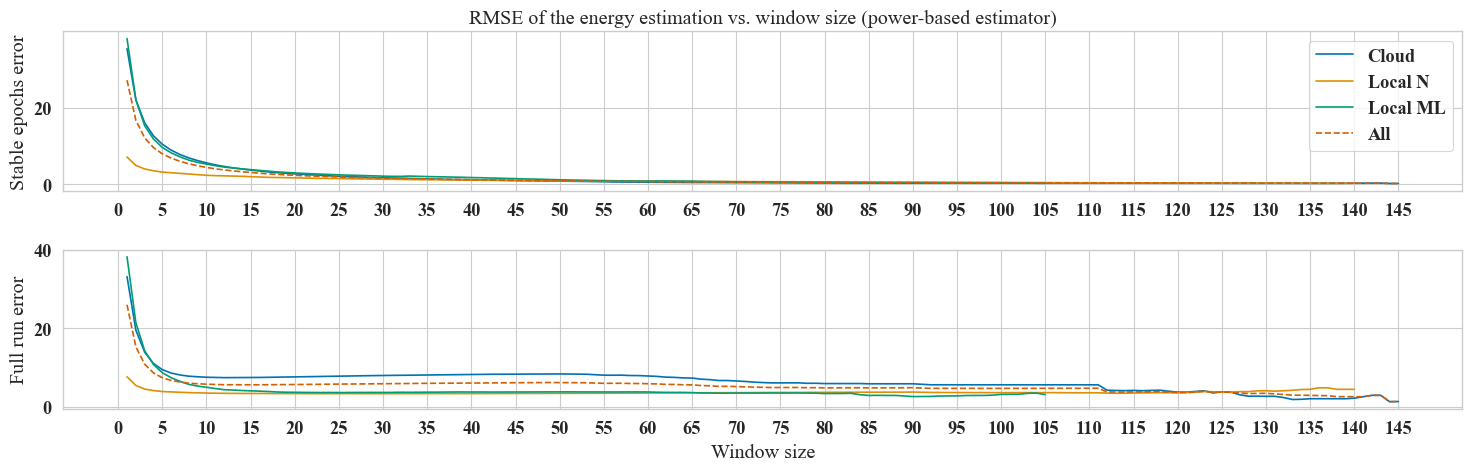

In [30]:
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(15, 5))

labels = {"local": "Local N", "local-v2": "Local ML", "cloud": "Cloud"}
for i, train_environment in enumerate(energy_estimation_from_first_epochs["training environment"].unique()):
    data = energy_estimation_from_first_epochs.query("`training environment` == @train_environment")
    rmse_method_1 = data.groupby("window size")[["energy (kJ)", "estimated energy (kJ) (online power-based)"]].apply(
        lambda g: root_mean_squared_error(g["energy (kJ)"], g["estimated energy (kJ) (online power-based)"])
    )
    rmse_method_2 = data.groupby("window size")[
        ["total energy (kJ)", "estimated total energy (kJ) (online power-based)"]
    ].apply(
        lambda g: root_mean_squared_error(g["total energy (kJ)"], g["estimated total energy (kJ) (online power-based)"])
    )

    ax0.plot(rmse_method_1.index, rmse_method_1, label=labels[train_environment])
    ax1.plot(rmse_method_2.index, rmse_method_2, label=labels[train_environment])

rmse_method_1 = energy_estimation_from_first_epochs.groupby("window size")[
    ["energy (kJ)", "estimated energy (kJ) (online power-based)"]
].apply(lambda g: root_mean_squared_error(g["energy (kJ)"], g["estimated energy (kJ) (online power-based)"]))
rmse_method_2 = energy_estimation_from_first_epochs.groupby("window size")[
    ["total energy (kJ)", "estimated total energy (kJ) (online power-based)"]
].apply(
    lambda g: root_mean_squared_error(g["total energy (kJ)"], g["estimated total energy (kJ) (online power-based)"])
)
ax0.plot(rmse_method_1.index, rmse_method_1, label="All", color="r", linestyle="dashed")
ax1.plot(rmse_method_2.index, rmse_method_2, label="All", color="r", linestyle="dashed")

ax0.legend()
ax0.set_title("RMSE of the energy estimation vs. window size (power-based estimator)")
ax0.set_ylabel("Stable epochs error")
ax1.set_ylabel("Full run error")
ax1.set_xlabel("Window size")
stop = energy_estimation_from_first_epochs["window size"].max() + 1
ax0.set_xticks(np.arange(0, stop, 5))
ax1.set_xticks(np.arange(0, stop, 5))

if SAVE_FIGS:
    plt.savefig(SAVE_FIGS_DIR / f"energy-estimation-vs-window-size-method-1.{FIGURES_FORMAT}", format=FIGURES_FORMAT)

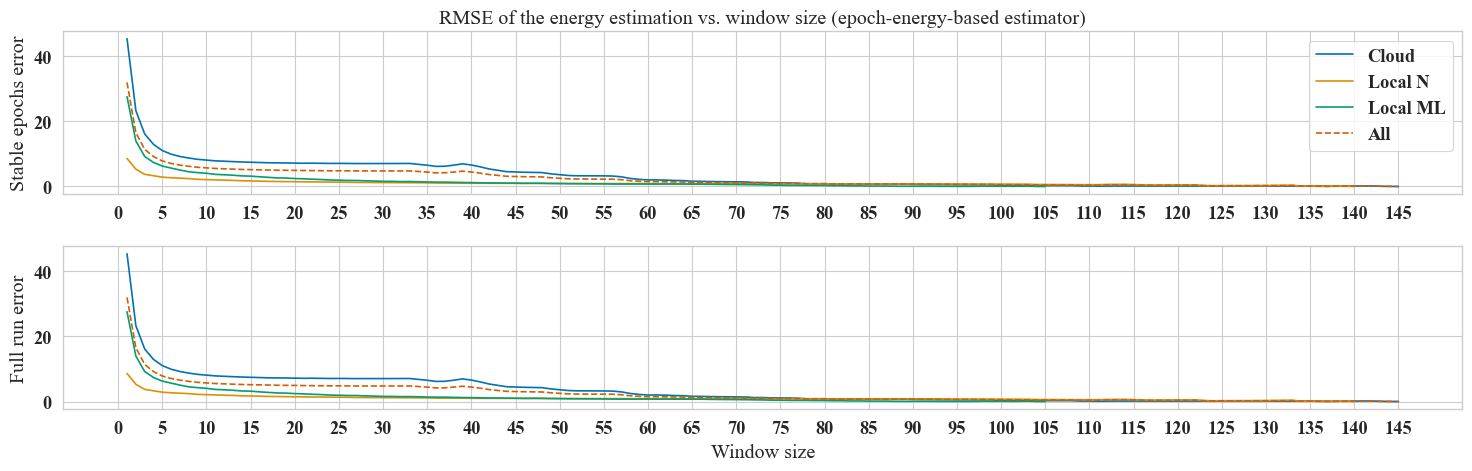

In [31]:
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(15, 5))

for i, train_environment in enumerate(energy_estimation_from_first_epochs["training environment"].unique()):
    data = energy_estimation_from_first_epochs.query("`training environment` == @train_environment")
    rmse_method_1 = data.groupby("window size")[
        ["energy (kJ)", "estimated energy (kJ) (online epoch-energy-based)"]
    ].apply(lambda g: root_mean_squared_error(g["energy (kJ)"], g["estimated energy (kJ) (online epoch-energy-based)"]))
    rmse_method_2 = data.groupby("window size")[
        ["total energy (kJ)", "estimated total energy (kJ) (online epoch-energy-based)"]
    ].apply(
        lambda g: root_mean_squared_error(
            g["total energy (kJ)"], g["estimated total energy (kJ) (online epoch-energy-based)"]
        )
    )
    ax0.plot(rmse_method_1.index, rmse_method_1, label=labels[train_environment])
    ax1.plot(rmse_method_2.index, rmse_method_2, label=labels[train_environment])

rmse_method_1 = energy_estimation_from_first_epochs.groupby("window size")[
    ["energy (kJ)", "estimated energy (kJ) (online epoch-energy-based)"]
].apply(lambda g: root_mean_squared_error(g["energy (kJ)"], g["estimated energy (kJ) (online epoch-energy-based)"]))
rmse_method_2 = energy_estimation_from_first_epochs.groupby("window size")[
    ["total energy (kJ)", "estimated total energy (kJ) (online epoch-energy-based)"]
].apply(
    lambda g: root_mean_squared_error(
        g["total energy (kJ)"], g["estimated total energy (kJ) (online epoch-energy-based)"]
    )
)
ax0.plot(rmse_method_1.index, rmse_method_1, label="All", color="r", linestyle="dashed")
ax1.plot(rmse_method_2.index, rmse_method_2, label="All", color="r", linestyle="dashed")

ax0.legend()
ax0.set_title("RMSE of the energy estimation vs. window size (epoch-energy-based estimator)")
ax0.set_ylabel("Stable epochs error")
ax1.set_ylabel("Full run error")
ax1.set_xlabel("Window size")
stop = energy_estimation_from_first_epochs["window size"].max() + 1
ax0.set_xticks(np.arange(0, stop, 5))
ax1.set_xticks(np.arange(0, stop, 5))

if SAVE_FIGS:
    plt.savefig(SAVE_FIGS_DIR / f"energy-estimation-vs-window-size-method-2.{FIGURES_FORMAT}", format=FIGURES_FORMAT)

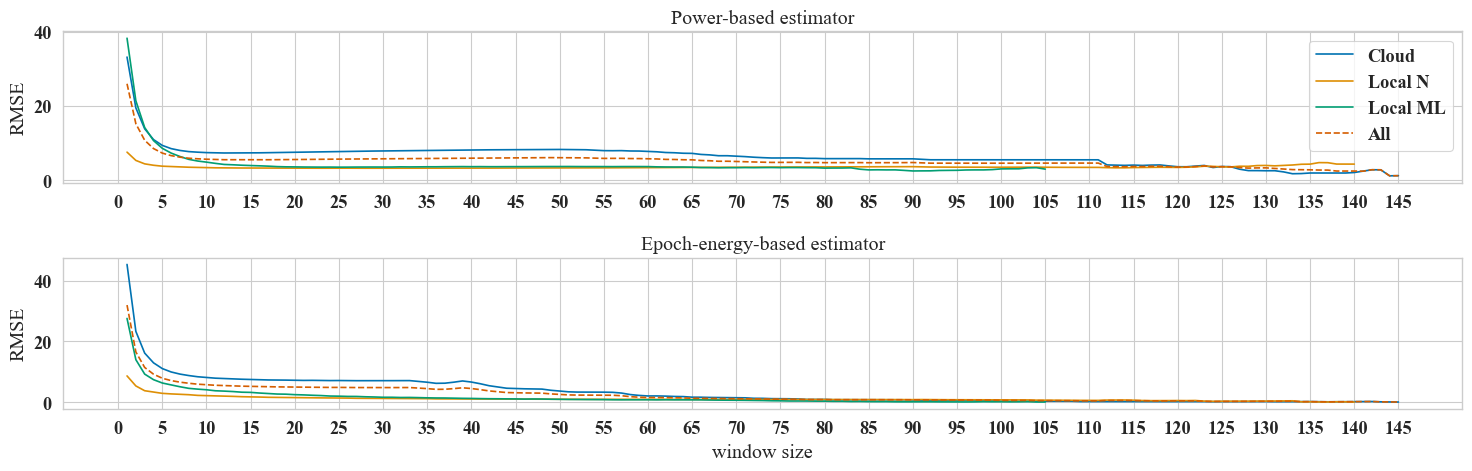

In [32]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(15, 5))

for i, train_environment in enumerate(energy_estimation_from_first_epochs["training environment"].unique()):
    data = energy_estimation_from_first_epochs.query("`training environment` == @train_environment")
    rmse_method_1 = data.groupby("window size")[
        ["total energy (kJ)", "estimated total energy (kJ) (online power-based)"]
    ].apply(
        lambda g: root_mean_squared_error(g["total energy (kJ)"], g["estimated total energy (kJ) (online power-based)"])
    )
    rmse_method_2 = data.groupby("window size")[
        ["total energy (kJ)", "estimated total energy (kJ) (online epoch-energy-based)"]
    ].apply(
        lambda g: root_mean_squared_error(
            g["total energy (kJ)"], g["estimated total energy (kJ) (online epoch-energy-based)"]
        )
    )
    ax0.plot(rmse_method_1.index, rmse_method_1, label=labels[train_environment])
    ax1.plot(rmse_method_2.index, rmse_method_2, label=labels[train_environment])

rmse_method_1 = energy_estimation_from_first_epochs.groupby("window size")[
    ["total energy (kJ)", "estimated total energy (kJ) (online power-based)"]
].apply(
    lambda g: root_mean_squared_error(g["total energy (kJ)"], g["estimated total energy (kJ) (online power-based)"])
)
rmse_method_2 = energy_estimation_from_first_epochs.groupby("window size")[
    ["total energy (kJ)", "estimated total energy (kJ) (online epoch-energy-based)"]
].apply(
    lambda g: root_mean_squared_error(
        g["total energy (kJ)"], g["estimated total energy (kJ) (online epoch-energy-based)"]
    )
)
ax0.plot(rmse_method_1.index, rmse_method_1, label="All", color="r", linestyle="dashed")
ax1.plot(rmse_method_2.index, rmse_method_2, label="All", color="r", linestyle="dashed")

ax0.legend()
ax0.set_title("Power-based estimator")
ax0.set_ylabel("RMSE")
ax1.set_title("Epoch-energy-based estimator")
ax1.set_ylabel("RMSE")
ax1.set_xlabel("window size")
stop = energy_estimation_from_first_epochs["window size"].max() + 1
ax0.set_xticks(np.arange(0, stop, 5))
ax1.set_xticks(np.arange(0, stop, 5))

if SAVE_FIGS:
    plt.savefig(SAVE_FIGS_DIR / f"energy-estimation-vs-window-size.{FIGURES_FORMAT}", format=FIGURES_FORMAT)

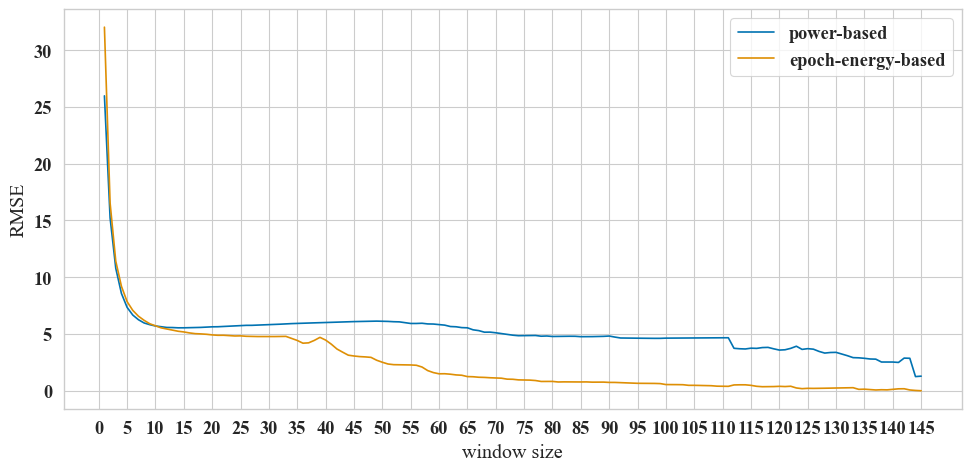

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))

rmse_method_1 = energy_estimation_from_first_epochs.groupby("window size")[
    ["total energy (kJ)", "estimated total energy (kJ) (online power-based)"]
].apply(
    lambda g: root_mean_squared_error(g["total energy (kJ)"], g["estimated total energy (kJ) (online power-based)"])
)
rmse_method_2 = energy_estimation_from_first_epochs.groupby("window size")[
    ["total energy (kJ)", "estimated total energy (kJ) (online epoch-energy-based)"]
].apply(
    lambda g: root_mean_squared_error(
        g["total energy (kJ)"], g["estimated total energy (kJ) (online epoch-energy-based)"]
    )
)
ax.plot(rmse_method_1.index, rmse_method_1, label="power-based")
ax.plot(rmse_method_2.index, rmse_method_2, label="epoch-energy-based")

ax.legend()
ax.set_ylabel("RMSE")
ax.set_xlabel("window size")
stop = energy_estimation_from_first_epochs["window size"].max() + 5
ax.set_xticks(np.arange(0, stop, 5))
ax.set_xticks(np.arange(0, stop, 5))

if SAVE_FIGS:
    plt.savefig(SAVE_FIGS_DIR / f"energy-estimation-vs-window-size-merged.{FIGURES_FORMAT}", format=FIGURES_FORMAT)

In [34]:
window_size = 5
y_data = energy_estimation_from_first_epochs.query("`window size` == 5")
y_true = y_data["total energy (kJ)"]
y_pred = y_data["estimated total energy (kJ) (online power-based)"]
method_1_rmse_from_first_epochs = root_mean_squared_error(y_true, y_pred)
# (window mean gpu power + mean ram power) * training duration
print(f"RMSE (online power-based estimator) with a window size of {window_size}: {method_1_rmse_from_first_epochs}")

RMSE (online power-based estimator) with a window size of 5: 7.341743116631787


In [35]:
y_pred = y_data["estimated total energy (kJ) (online epoch-energy-based)"]
# (window total energy * window_size/#epochs)
method_2_rmse_from_first_epochs = root_mean_squared_error(y_true, y_pred)
print(
    f"RMSE (online epoch-energy-based estimator) with a window size of {window_size}: {method_2_rmse_from_first_epochs}"
)

RMSE (online epoch-energy-based estimator) with a window size of 5: 7.8479830591425275


In [36]:
y_data = y_data.drop_duplicates(subset=["run_id"])
y_true = y_data["total energy (kJ)"]
y_pred = y_data["estimated total energy (kJ) (GA)"]
# (max gpu power * gpu usage + memory used * W/MB) * training duration
print(f"RMSE (GA): {root_mean_squared_error(y_true, y_pred)}")

RMSE (GA): 176.57246698687615


In [37]:
y_pred = y_data["estimated total energy (kJ) (MLCO2)"]
# max gpu power * training duration
print(f"RMSE (MLCO2): {root_mean_squared_error(y_true, y_pred)}")

RMSE (MLCO2): 187.33066390601846


In [38]:
if not os.path.exists(DATA_DIR / "analysis" / "processed" / "mean_power_draw_by_epoch_start.pkl"):
    groups = metrics.groupby("run_id")
    mean_power_draw_by_epoch_start = {
        "run_id": [],
        "stabilizing epoch": [],
        "window size": [],
        "mean gpu power draw": [],
        "mean ram power draw": [],
        "energy (J)": [],
        "initial energy (J)": [],
        "total epochs": [],
    }
    for run_id, group in tqdm(groups, total=len(groups)):
        n_epochs = group["epoch"].nunique()
        for starting_epoch in np.arange(n_epochs - window_size):
            data = group.query("`epoch` >= @starting_epoch and `epoch` < (@starting_epoch + @window_size)")
            mean_gpu_power_by_epoch_start = data["gpu_power_draw"].mean()
            mean_ram_power_by_epoch_start = data["memory_power_draw"].mean()

            epoch_data = epoch_energy_df.query(
                "`run_id` == @run_id and `epoch` >= @starting_epoch and `epoch` < (@starting_epoch + @window_size)"
            )
            energy = epoch_data["total energy (kJ)"].sum() * KJOULES_TO_JOULES
            initial_energy = (
                epoch_energy_df.query("run_id == @run_id and epoch < @starting_epoch")["total energy (kJ)"].sum()
                * KJOULES_TO_JOULES
            )

            mean_power_draw_by_epoch_start["run_id"].append(run_id)
            mean_power_draw_by_epoch_start["stabilizing epoch"].append(starting_epoch)
            mean_power_draw_by_epoch_start["total epochs"].append(n_epochs)
            mean_power_draw_by_epoch_start["window size"].append(window_size)
            mean_power_draw_by_epoch_start["mean gpu power draw"].append(mean_gpu_power_by_epoch_start)
            mean_power_draw_by_epoch_start["mean ram power draw"].append(mean_ram_power_by_epoch_start)
            mean_power_draw_by_epoch_start["energy (J)"].append(energy)
            mean_power_draw_by_epoch_start["initial energy (J)"].append(initial_energy)

    with open(DATA_DIR / "analysis" / "processed" / "mean_power_draw_by_epoch_start.pkl", "wb") as f:
        pickle.dump(mean_power_draw_by_epoch_start, f)
else:
    with open(DATA_DIR / "analysis" / "processed" / "mean_power_draw_by_epoch_start.pkl", "rb") as f:
        mean_power_draw_by_epoch_start = pickle.load(f)

In [39]:
energy_estimation_by_epoch_start = pd.DataFrame.from_dict(mean_power_draw_by_epoch_start, orient="columns")
energy_estimation_by_epoch_start = energy_estimation_by_epoch_start.merge(
    aggregated_metrics[
        INDEPENDENT_VARIABLES
        + [
            "run_id",
            "training duration (h)",
            "average gpu power (W)",
            "max power limit (W)",
            "gpu usage (%)",
            "energy (MJ)",
        ]
    ],
    on="run_id",
    how="inner",
)

energy_estimation_by_epoch_start["total energy (kJ)"] = (
    energy_estimation_by_epoch_start["energy (MJ)"] * MJOULES_TO_KJOULES
)
energy_estimation_by_epoch_start["gpu usage (%)"] = energy_estimation_by_epoch_start["gpu usage (%)"] / 100
# energy = window average power * training duration
energy_estimation_by_epoch_start["estimated energy (kJ) (online power-based)"] = (
    (
        energy_estimation_by_epoch_start["mean gpu power draw"].fillna(0)
        + energy_estimation_by_epoch_start["mean ram power draw"].fillna(0)
    )
    * energy_estimation_by_epoch_start["training duration (h)"]
    * HOURS_TO_SECONDS
    * JOULES_TO_KJOULES
)

# energy = window total energy * #epochs/window size
energy_estimation_by_epoch_start["estimated energy (kJ) (online epoch-energy-based)"] = (
    energy_estimation_by_epoch_start["initial energy (J)"]
    + energy_estimation_by_epoch_start["energy (J)"]
    * (energy_estimation_by_epoch_start["total epochs"] - energy_estimation_by_epoch_start["stabilizing epoch"])
    / energy_estimation_by_epoch_start["window size"]
) * JOULES_TO_KJOULES

# energy = (TDP * gpu usage + (ram used * C)) * training duration
energy_estimation_by_epoch_start["estimated energy (kJ) (GA)"] = (
    (
        energy_estimation_by_epoch_start["max power limit (W)"] * energy_estimation_by_epoch_start["gpu usage (%)"]
        + energy_estimation_by_epoch_start["mean ram power draw"].fillna(0)
    )
    * energy_estimation_by_epoch_start["training duration (h)"]
    * HOURS_TO_SECONDS
    * JOULES_TO_KJOULES
)

# energy = TDP * training duration
energy_estimation_by_epoch_start["estimated energy (kJ) (MLCO2)"] = (
    energy_estimation_by_epoch_start["max power limit (W)"]
    * energy_estimation_by_epoch_start["training duration (h)"]
    * HOURS_TO_SECONDS
    * JOULES_TO_KJOULES
)

# energy_estimation_by_epoch_start["squared error (online power-based)"] = (
#     energy_estimation_by_epoch_start["estimated energy (kJ) (online power-based)"]
#     - energy_estimation_by_epoch_start["energy (kJ)"]
# ) ** 2
# energy_estimation_by_epoch_start["squared error (online epoch-energy-based)"] = (
#     energy_estimation_by_epoch_start["estimated energy (kJ) (online epoch-energy-based)"]
#     - energy_estimation_by_epoch_start["energy (kJ)"]
# ) ** 2
# energy_estimation_by_epoch_start["squared error (GA)"] = (
#     energy_estimation_by_epoch_start["estimated energy (kJ) (GA)"]
#     - energy_estimation_by_epoch_start["energy (kJ)"]
# ) ** 2
# energy_estimation_by_epoch_start["squared error (MLCO2)"] = (
#     energy_estimation_by_epoch_start["estimated energy (kJ) (MLCO2)"]
#     - energy_estimation_by_epoch_start["energy (kJ)"]
# ) ** 2

In [40]:
energy_estimation_by_epoch_start.head()

,run_id,stabilizing epoch,window size,mean gpu power draw,mean ram power draw,energy (J),initial energy (J),total epochs,training environment,architecture,...,training duration (h),average gpu power (W),max power limit (W),gpu usage (%),energy (MJ),total energy (kJ),estimated energy (kJ) (online power-based),estimated energy (kJ) (online epoch-energy-based),estimated energy (kJ) (GA),estimated energy (kJ) (MLCO2)
0,00131e286bc847e4a0447e0944ba95b6,0,5,128.235294,1.552297,4284.299035,0.000000,126,Cloud,inception_v3,...,0.086514,144.929487,350.0,0.291538,0.045912,45.911829,40.422475,107.964336,32.263445,109.00785
1,00131e286bc847e4a0447e0944ba95b6,1,5,153.000000,2.517347,1856.693784,2723.082007,126,Cloud,inception_v3,...,0.086514,144.929487,350.0,0.291538,0.045912,45.911829,48.436033,49.140427,32.564011,109.00785
2,00131e286bc847e4a0447e0944ba95b6,2,5,145.454545,2.517357,1652.783681,3226.826339,126,Cloud,inception_v3,...,0.086514,144.929487,350.0,0.291538,0.045912,45.911829,46.085997,44.215862,32.564014,109.00785
3,00131e286bc847e4a0447e0944ba95b6,3,5,145.909091,2.517352,1635.619608,3543.824629,126,Cloud,inception_v3,...,0.086514,144.929487,350.0,0.291538,0.045912,45.911829,46.227564,43.780067,32.564013,109.00785
4,00131e286bc847e4a0447e0944ba95b6,4,5,146.916667,2.517345,1790.592932,3838.653893,126,Cloud,inception_v3,...,0.086514,144.929487,350.0,0.291538,0.045912,45.911829,46.541372,47.529121,32.564010,109.00785


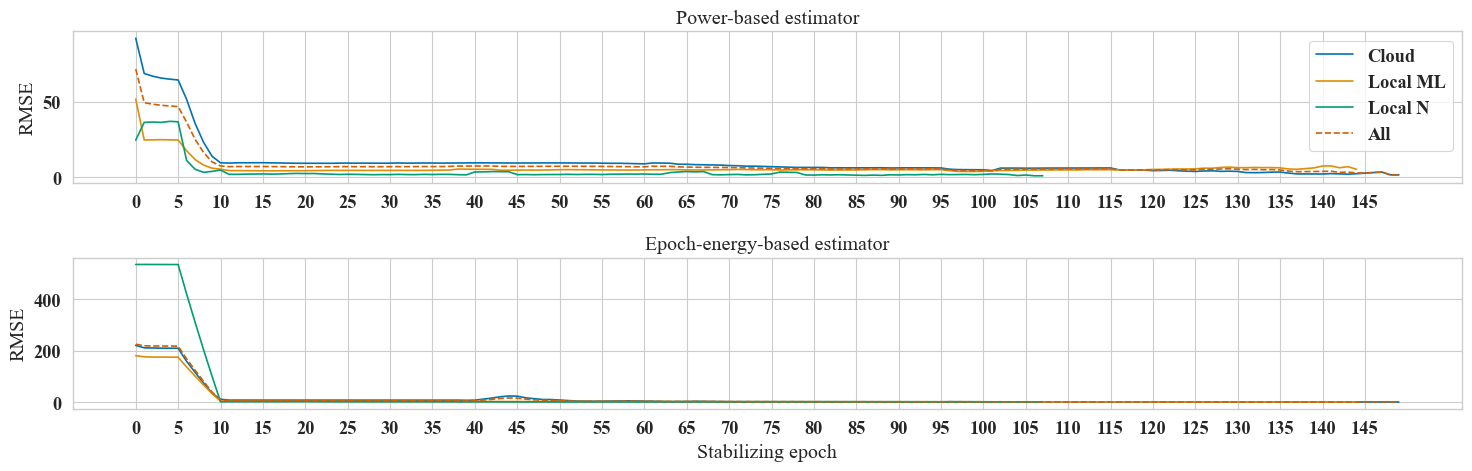

In [41]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(15, 5))

for i, train_environment in enumerate(energy_estimation_by_epoch_start["training environment"].unique()):
    data = energy_estimation_by_epoch_start.query("`training environment` == @train_environment")
    rmse_method_1 = data.groupby("stabilizing epoch")[
        ["total energy (kJ)", "estimated energy (kJ) (online power-based)"]
    ].apply(lambda g: root_mean_squared_error(g["total energy (kJ)"], g["estimated energy (kJ) (online power-based)"]))
    rmse_method_2 = data.groupby("stabilizing epoch")[
        ["total energy (kJ)", "estimated energy (kJ) (online epoch-energy-based)"]
    ].apply(
        lambda g: root_mean_squared_error(
            g["total energy (kJ)"], g["estimated energy (kJ) (online epoch-energy-based)"]
        )
    )
    ax0.plot(rmse_method_1.index, rmse_method_1, label=train_environment)
    ax1.plot(rmse_method_2.index, rmse_method_2, label=train_environment)

rmse_method_1 = energy_estimation_by_epoch_start.groupby("stabilizing epoch")[
    ["total energy (kJ)", "estimated energy (kJ) (online power-based)"]
].apply(lambda g: root_mean_squared_error(g["total energy (kJ)"], g["estimated energy (kJ) (online power-based)"]))
rmse_method_2 = energy_estimation_by_epoch_start.groupby("stabilizing epoch")[
    ["total energy (kJ)", "estimated energy (kJ) (online epoch-energy-based)"]
].apply(
    lambda g: root_mean_squared_error(g["total energy (kJ)"], g["estimated energy (kJ) (online epoch-energy-based)"])
)
ax0.plot(rmse_method_1.index, rmse_method_1, label="All", color="r", linestyle="dashed")
ax1.plot(rmse_method_2.index, rmse_method_2, label="All", color="r", linestyle="dashed")

ax0.legend()
ax0.set_title("Power-based estimator")
ax0.set_ylabel("RMSE")
ax1.set_title("Epoch-energy-based estimator")
ax1.set_ylabel("RMSE")
ax1.set_xlabel("Stabilizing epoch")
stop = energy_estimation_by_epoch_start["stabilizing epoch"].max() + 1
ax0.set_xticks(np.arange(0, stop, 5))
ax1.set_xticks(np.arange(0, stop, 5))

if SAVE_FIGS:
    plt.savefig(SAVE_FIGS_DIR / f"energy-estimation-vs-stabilizing-epoch.{FIGURES_FORMAT}", format=FIGURES_FORMAT)

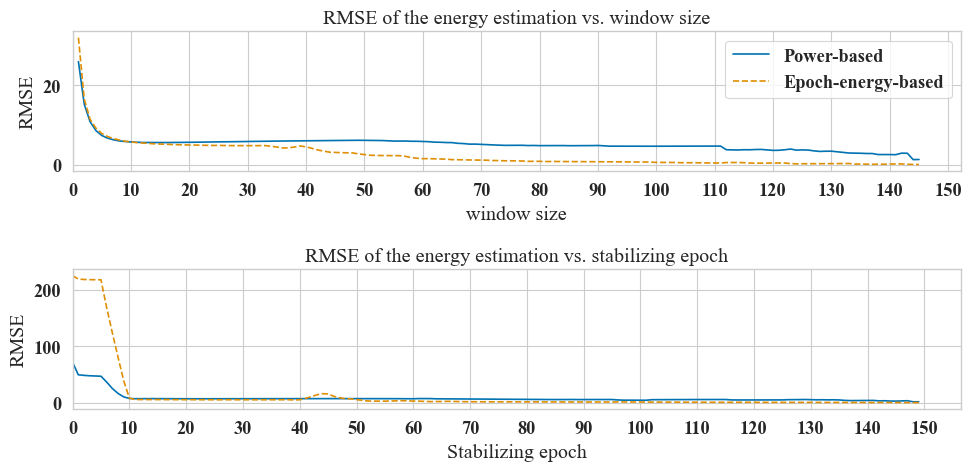

In [42]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 5))


rmse_method_1 = energy_estimation_from_first_epochs.groupby("window size")[
    ["total energy (kJ)", "estimated total energy (kJ) (online power-based)"]
].apply(
    lambda g: root_mean_squared_error(g["total energy (kJ)"], g["estimated total energy (kJ) (online power-based)"])
)
rmse_method_2 = energy_estimation_from_first_epochs.groupby("window size")[
    ["total energy (kJ)", "estimated total energy (kJ) (online epoch-energy-based)"]
].apply(
    lambda g: root_mean_squared_error(
        g["total energy (kJ)"], g["estimated total energy (kJ) (online epoch-energy-based)"]
    )
)
ax0.plot(rmse_method_1.index, rmse_method_1, label="Power-based")
ax0.plot(rmse_method_2.index, rmse_method_2, linestyle="--", label="Epoch-energy-based")

ax0.set_title("RMSE of the energy estimation vs. window size")
ax0.legend()
ax0.set_ylabel("RMSE")
ax0.set_xlabel("window size")
stop = energy_estimation_from_first_epochs["window size"].max() + 10
ax0.set_xticks(np.arange(0, stop, 10))
ax0.set_xlim(left=0)

rmse_method_1 = energy_estimation_by_epoch_start.groupby("stabilizing epoch")[
    ["total energy (kJ)", "estimated energy (kJ) (online power-based)"]
].apply(lambda g: root_mean_squared_error(g["total energy (kJ)"], g["estimated energy (kJ) (online power-based)"]))
rmse_method_2 = energy_estimation_by_epoch_start.groupby("stabilizing epoch")[
    ["total energy (kJ)", "estimated energy (kJ) (online epoch-energy-based)"]
].apply(
    lambda g: root_mean_squared_error(g["total energy (kJ)"], g["estimated energy (kJ) (online epoch-energy-based)"])
)
ax1.plot(rmse_method_1.index, rmse_method_1, label="online power-based")
ax1.plot(rmse_method_2.index, rmse_method_2, linestyle="--", label="online epoch-energy-based")

ax1.set_title("RMSE of the energy estimation vs. stabilizing epoch")
ax1.set_ylabel("RMSE")
ax1.set_xlabel("Stabilizing epoch")
stop = energy_estimation_by_epoch_start["stabilizing epoch"].max() + 5
ax1.set_xticks(np.arange(0, stop, 10))
ax1.set_xlim(left=0)

if SAVE_FIGS:
    plt.savefig(
        SAVE_FIGS_DIR / f"energy-estimation-vs-window-size-and-stabilizing-epoch.{FIGURES_FORMAT}",
        format=FIGURES_FORMAT,
    )

##### Does it matter which epochs we use to estimate the energy consumption?

Here we will try to estimate the energy consumption of a run based on the power consumption of a random starting epoch.


In [43]:
if not os.path.exists(DATA_DIR / "analysis" / "processed" / "mean_power_draw_random.pkl"):
    groups = metrics.groupby("run_id")
    mean_power_draw_random = {
        "run_id": [],
        "start epoch": [],
        "window size": [],
        "mean gpu power draw": [],
        "mean ram power draw": [],
        "energy (J)": [],
    }
    for run_id, group in groups:
        stable_epochs = group.query("`epoch` >= @stabilizing_epoch")["epoch"].unique()
        start_epoch = rng.choice(stable_epochs[:-window_size], size=1)[0]
        data = group.query("epoch >= @start_epoch and epoch < (@start_epoch + @window_size)")
        mean_gpu_power = data["gpu_power_draw"].mean()
        mean_ram_power = data["memory_power_draw"].mean()

        epoch_data = epoch_energy_df.query(
            "run_id == @run_id and epoch >= @start_epoch and epoch < (@start_epoch + @window_size)"
        )
        energy = epoch_data["total energy (kJ)"].sum() * KJOULES_TO_JOULES

        mean_power_draw_random["run_id"].append(run_id)
        mean_power_draw_random["start epoch"].append(start_epoch)
        mean_power_draw_random["window size"].append(window_size)
        mean_power_draw_random["mean gpu power draw"].append(mean_gpu_power)
        mean_power_draw_random["mean ram power draw"].append(mean_ram_power)
        mean_power_draw_random["energy (J)"].append(energy)

    with open(DATA_DIR / "analysis" / "processed" / "mean_power_draw_random.pkl", "wb") as f:
        pickle.dump(mean_power_draw_random, f)
else:
    with open(DATA_DIR / "analysis" / "processed" / "mean_power_draw_random.pkl", "rb") as f:
        mean_power_draw_random = pickle.load(f)

In [44]:
energy_estimation_from_random = build_energy_estimation(mean_power_draw_random, stabilizing_epoch)
energy_estimation_from_random.head()

,run_id,start epoch,window size,mean gpu power draw,mean ram power draw,energy (J),training environment,architecture,dataset,training duration (h),...,total ram (GB),total energy (kJ),estimated energy (kJ) (online power-based),estimated total energy (kJ) (online power-based),estimated energy (kJ) (online epoch-energy-based),estimated total energy (kJ) (online epoch-energy-based),estimated energy (kJ) (GA),estimated total energy (kJ) (GA),estimated energy (kJ) (MLCO2),estimated total energy (kJ) (MLCO2)
0,00131e286bc847e4a0447e0944ba95b6,36,5,147.818182,2.517388,1656.998489,cloud,inception_v3,caltech101,0.073999,...,16.0,45.911829,40.048644,46.822164,38.442365,44.375100,30.683636,33.636229,93.23825,109.00785
1,00880f78cd0f458ba2a0d2ea72c88805,58,5,152.859873,5.084019,24827.305862,cloud,mobilenet_v2,chesslive-occupancy,0.673300,...,16.0,414.568054,382.836881,422.843753,382.340510,414.591998,222.307954,233.545913,848.35765,937.01195
2,009a03d661ed4b7cbe8a3cecd3e4fd3a,19,5,251.857143,2.694170,893.455463,cloud,inception_v3,caltech101,0.023119,...,16.0,25.710034,21.185797,29.231655,19.834711,24.185722,14.802783,16.499337,29.12980,40.19260
3,00bac5db17a74fe5bbfdbd9afb40652b,33,5,150.571429,3.206737,1079.652740,local,inception_v3,caltech101,0.042842,...,32.0,26.506558,23.717360,29.110053,24.832013,28.169776,27.004157,30.156327,37.01544,45.43176
4,00d71c4ea52f401594a7da33de788557,47,5,137.500000,3.153285,1407.276078,local,inception_v3,caltech101,0.070662,...,32.0,38.690266,35.779664,41.837179,34.337536,38.500356,42.543444,46.857361,61.05168,71.38776


In [45]:
y_data = energy_estimation_from_random
y_true = y_data["total energy (kJ)"]
y_pred = y_data["estimated total energy (kJ) (online power-based)"]
method_1_rmse_random = root_mean_squared_error(y_true, y_pred)
print(f"RMSE (online power-based estimator random) with a window size of {window_size}: {method_1_rmse_random}")
y_pred = y_data["estimated total energy (kJ) (online epoch-energy-based)"]
method_2_rmse_random = root_mean_squared_error(y_true, y_pred)
print(f"RMSE (online epoch-energy-based estimator random) with a window size of {window_size}: {method_2_rmse_random}")

RMSE (online power-based estimator random) with a window size of 5: 6.966705747479035
RMSE (online epoch-energy-based estimator random) with a window size of 5: 5.167453985222906


In [46]:
print(f"Improvement of online power-based estimator: {method_1_rmse_from_first_epochs - method_1_rmse_random}")
print(f"Improvement of online epoch-energy-based estimator: {method_2_rmse_from_first_epochs - method_2_rmse_random}")

Improvement of online power-based estimator: 0.37503736915275177
Improvement of online epoch-energy-based estimator: 2.6805290739196215


As we can see from the previous results, the difference between using the first epoch and a random epoch is negligible.
Hence, to estimate the energy consumption of a run, we only need to measure the power consumption of three epochs at any point after the stabilizing epoch.


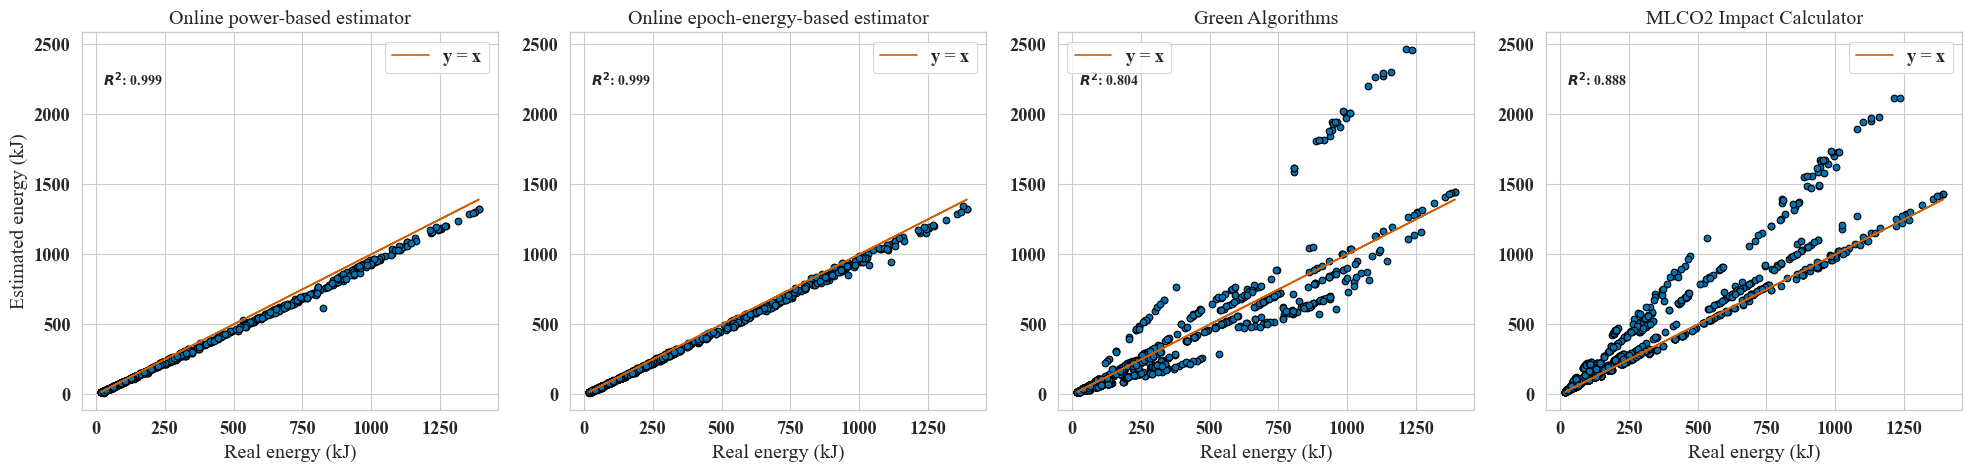

In [47]:
plt.figure(figsize=(20, 5))

x = energy_estimation_from_first_epochs.query("`window size` == 5")["total energy (kJ)"]
y = energy_estimation_from_first_epochs.query("`window size` == 5")["estimated energy (kJ) (online power-based)"]
_, _, r_value, _, _ = stats.linregress(x, y)
ax = plt.subplot(141)
ax.scatter(x, y)
ax.plot(x, x, color="r", label="y = x")
ax.set_title("Online power-based estimator")
ax.set_xlabel("Real energy (kJ)")
ax.set_ylabel("Estimated energy (kJ)")
ax.text(0.05, 0.9, f"$R^2$: {r_value**2:.3f}", transform=ax.transAxes, fontsize=10, verticalalignment="top")
ax.legend()

y = energy_estimation_from_first_epochs.query("`window size` == 5")["estimated energy (kJ) (online epoch-energy-based)"]
_, _, r_value, _, _ = stats.linregress(x, y)
ax = plt.subplot(142, sharey=ax)
ax.scatter(x, y)
ax.plot(x, x, color="r", label="y = x")
ax.set_title("Online epoch-energy-based estimator")
ax.set_xlabel("Real energy (kJ)")
# ax.set_ylabel("Estimated energy (kJ)")
ax.text(0.05, 0.9, f"$R^2$: {r_value**2:.3f}", transform=ax.transAxes, fontsize=10, verticalalignment="top")
ax.legend()


y = energy_estimation_from_random.drop_duplicates(subset=["run_id"])["estimated energy (kJ) (GA)"]
_, _, r_value, _, _ = stats.linregress(x, y)
ax = plt.subplot(143, sharey=ax)
ax.scatter(x, y)
ax.plot(x, x, color="r", label="y = x")
ax.set_title("Green Algorithms")
ax.set_xlabel("Real energy (kJ)")
# ax.set_ylabel("Estimated energy (kJ)")
ax.text(0.05, 0.9, f"$R^2$: {r_value**2:.3f}", transform=ax.transAxes, fontsize=10, verticalalignment="top")
ax.legend()

y = energy_estimation_from_random.drop_duplicates(subset=["run_id"])["estimated energy (kJ) (MLCO2)"]
_, _, r_value, _, _ = stats.linregress(x, y)
ax = plt.subplot(144, sharey=ax)
ax.scatter(x, y)
ax.plot(x, x, color="r", label="y = x")
ax.set_title("MLCO2 Impact Calculator")
ax.set_xlabel("Real energy (kJ)")
# ax.set_ylabel("Estimated energy (kJ)")
ax.text(0.05, 0.9, f"$R^2$: {r_value**2:.3f}", transform=ax.transAxes, fontsize=10, verticalalignment="top")
ax.legend()

plt.tight_layout()

if SAVE_FIGS:
    plt.savefig(SAVE_FIGS_DIR / f"energy-estimation-methods-comparison.{FIGURES_FORMAT}", dpi=300, bbox_inches="tight")

### How does GPU utilization affect the power consumption?


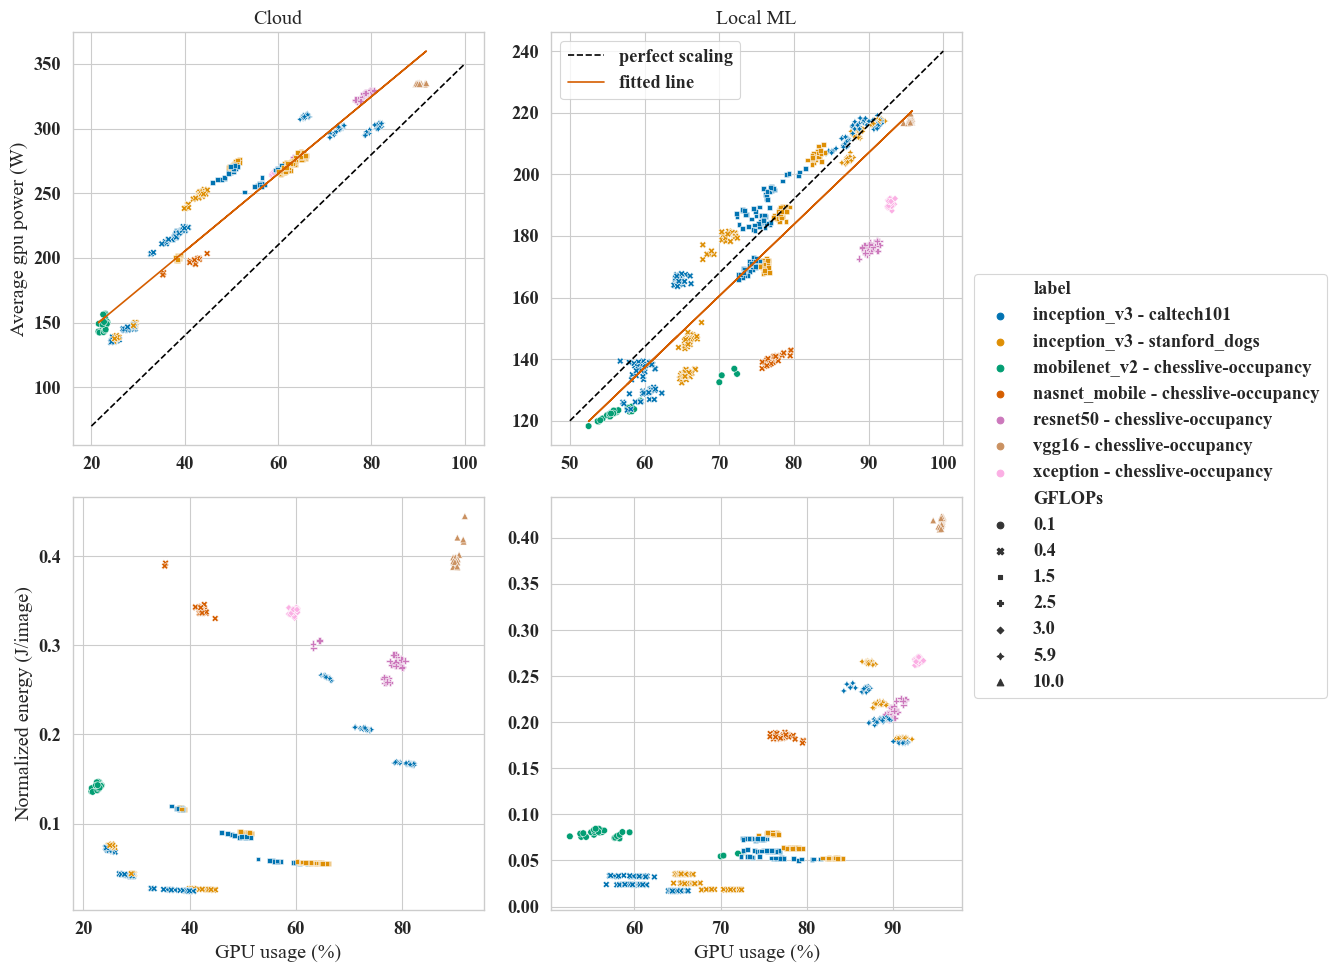

In [48]:
fig = plt.figure(figsize=(10, 10))

style = "GFLOPs"

tmp = aggregated_metrics.copy()
tmp["label"] = tmp["architecture"] + " - " + tmp["dataset"]
tmp.set_index("run_id", inplace=True)
tmp["average epoch energy (kJ)"] = epoch_energy_df.groupby("run_id")["total energy (kJ)"].mean()
tmp["average stable epoch energy (kJ)"] = (
    epoch_energy_df.query("epoch >= 10").groupby("run_id")["total energy (kJ)"].mean()
)
tmp.reset_index(drop=True, inplace=True)
tmp["normalized energy (J)"] = tmp["energy (MJ)"] / tmp["total seen images"] * MJOULES_TO_JOULES

ax = plt.subplot(221)
cloud_data = tmp.query("`training environment` == 'Cloud'")
cloud_data.loc[:, "GFLOPs"] = cloud_data["GFLOPs"].round(1)

sns.scatterplot(
    data=cloud_data,
    x="gpu usage (%)",
    y="average gpu power (W)",
    hue="label",
    hue_order=sorted(tmp["label"].unique()),
    style=style,
    palette="colorblind",
    ax=ax,
)
ax.plot(
    np.arange(20, 105, 5),
    np.arange(0.2, 1.05, 0.05) * cloud_data["max power limit (W)"].iloc[0],
    color="black",
    linestyle="--",
)

x = cloud_data["gpu usage (%)"]
y = cloud_data["average gpu power (W)"]
res = stats.linregress(x, y)
ax.plot(x, res.intercept + res.slope * x, "r", label="fitted line")

ax.set_xlabel("")
ax.set_ylabel("Average gpu power (W)")
ax.set_title("Cloud")
ax.legend_.remove()


ax = plt.subplot(222)
local_ml_data = tmp.query("`training environment` == 'Local ML'")
local_ml_data.loc[:, "GFLOPs"] = local_ml_data["GFLOPs"].round(1)

sns.scatterplot(
    data=local_ml_data,
    x="gpu usage (%)",
    y="average gpu power (W)",
    hue="label",
    hue_order=sorted(tmp["label"].unique()),
    style=style,
    palette="colorblind",
    ax=ax,
)
ax.plot(
    np.arange(50, 105, 5),
    np.arange(0.5, 1.05, 0.05) * local_ml_data["max power limit (W)"].iloc[0],
    color="black",
    linestyle="--",
    label="perfect scaling",
)

x = local_ml_data["gpu usage (%)"]
y = local_ml_data["average gpu power (W)"]
res = stats.linregress(x, y)
ax.plot(x, res.intercept + res.slope * x, "r", label="fitted line")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Local ML")

handlers, labels = ax.get_legend_handles_labels()
ax.legend(handlers[-2:], labels[-2:])
fig.legend(handlers[:-2], labels[:-2], loc="center right", bbox_to_anchor=(1.35, 0.5))

ax = plt.subplot(223)
sns.scatterplot(
    data=cloud_data,
    x="gpu usage (%)",
    y="normalized energy (J)",
    hue="label",
    hue_order=sorted(tmp["label"].unique()),
    style=style,
    palette="colorblind",
    ax=ax,
)
ax.set_xlabel("GPU usage (%)")
ax.set_ylabel("Normalized energy (J/image)")
ax.legend_.remove()


ax = plt.subplot(224)
sns.scatterplot(
    data=local_ml_data,
    x="gpu usage (%)",
    y="normalized energy (J)",
    hue="label",
    hue_order=sorted(tmp["label"].unique()),
    style=style,
    palette="colorblind",
    ax=ax,
)
ax.set_xlabel("GPU usage (%)")
ax.set_ylabel("")
ax.legend_.remove()

if SAVE_FIGS:
    plt.savefig(SAVE_FIGS_DIR / f"power-draw-vs-gpu-usage.{FIGURES_FORMAT}", dpi=300, bbox_inches="tight")

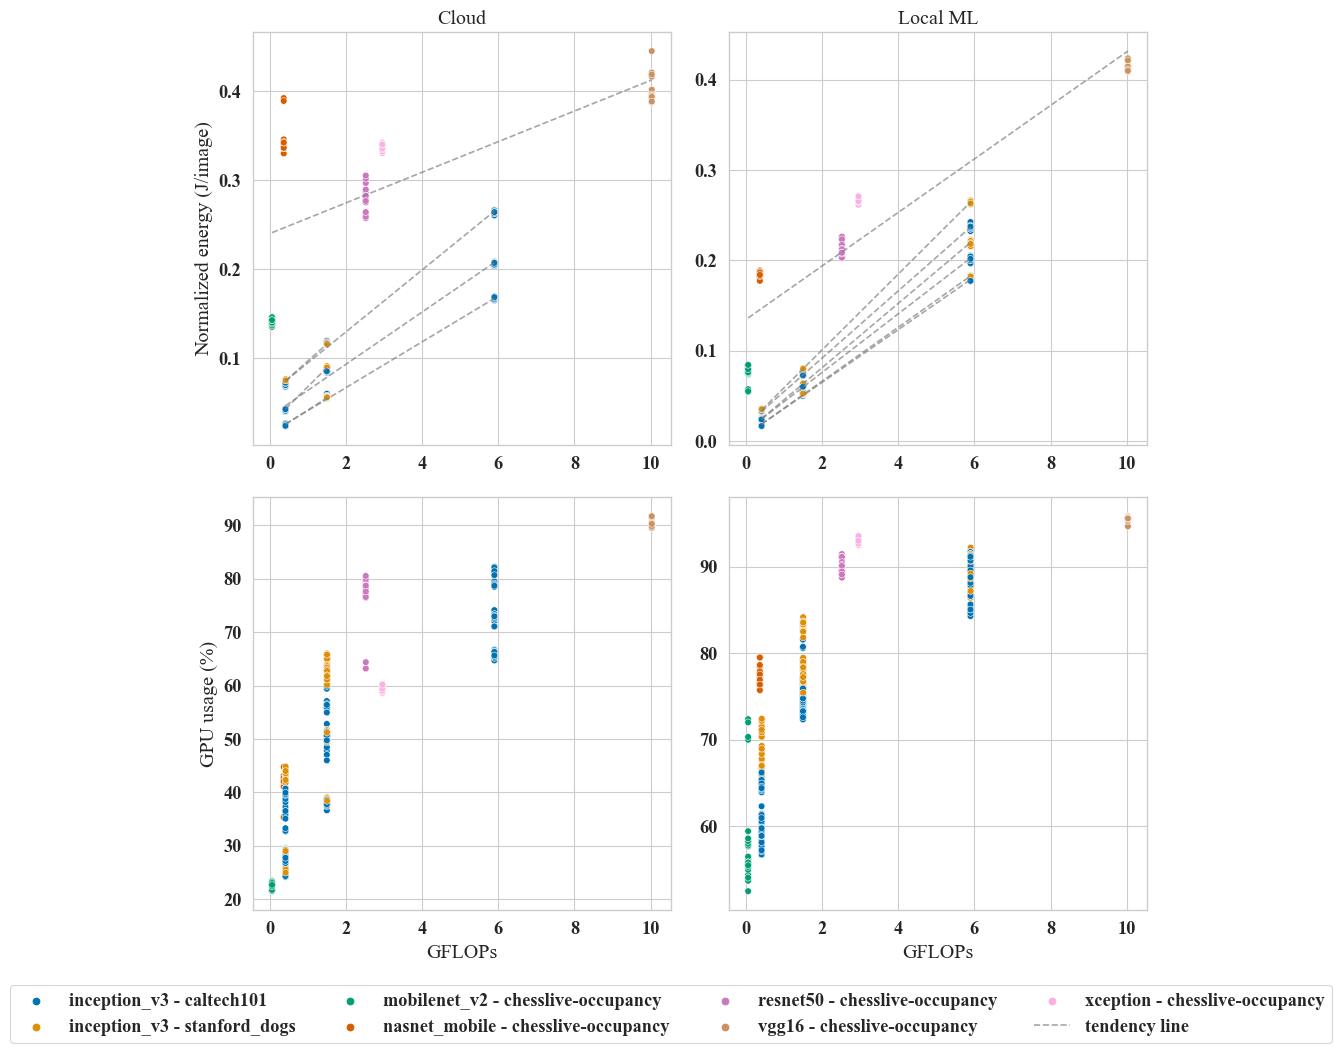

In [49]:
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(221)
cloud_data = tmp.query("`training environment` == 'Cloud'")

sns.scatterplot(
    data=cloud_data,
    x="GFLOPs",
    y="normalized energy (J)",
    hue="label",
    hue_order=sorted(tmp["label"].unique()),
    palette="colorblind",
    ax=ax,
)
ax.set_xlabel("")
ax.set_ylabel("Normalized energy (J/image)")
ax.set_title("Cloud")
ax.legend_.remove()

df = cloud_data.query("`architecture` != 'inception_v3'")
x = df["GFLOPs"]
y = df["normalized energy (J)"]
p = np.polynomial.Polynomial.fit(x, y, 1)
xx, yy = p.linspace()
ax.plot(xx, yy, linestyle="--", color="gray", alpha=0.7)

cloud_inception = cloud_data.query("`architecture` == 'inception_v3'")
for row in cloud_inception[["dataset", "batch size"]].drop_duplicates().itertuples():
    df = cloud_inception.query("`dataset` == @row[1] and `batch size` == @row[2]")
    x = df["GFLOPs"]
    y = df["normalized energy (J)"]

    p = np.polynomial.Polynomial.fit(x, y, 1)
    xx, yy = p.linspace()
    ax.plot(xx, yy, linestyle="--", color="gray", alpha=0.7)


ax = plt.subplot(222)
local_ml_data = tmp.query("`training environment` == 'Local ML'")

x = local_ml_data["gpu usage (%)"]
y = local_ml_data["energy (MJ)"]

sns.scatterplot(
    data=local_ml_data,
    x="GFLOPs",
    y="normalized energy (J)",
    hue="label",
    hue_order=sorted(tmp["label"].unique()),
    palette="colorblind",
    ax=ax,
)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Local ML")

df = local_ml_data.query("`architecture` != 'inception_v3'")
x = df["GFLOPs"]
y = df["normalized energy (J)"]

p = np.polynomial.Polynomial.fit(x, y, 1)
xx, yy = p.linspace()
ax.plot(xx, yy, linestyle="--", color="gray", alpha=0.7, label="tendency line")


local_inception = local_ml_data.query("`architecture` == 'inception_v3'")
for row in local_inception[["dataset", "batch size"]].drop_duplicates().itertuples():
    df = local_inception.query("`dataset` == @row[1] and `batch size` == @row[2]")
    x = df["GFLOPs"]
    y = df["normalized energy (J)"]

    p = np.polynomial.Polynomial.fit(x, y, 1)
    xx, yy = p.linspace()
    ax.plot(xx, yy, linestyle="--", color="gray", alpha=0.7)

handles, labels = ax.get_legend_handles_labels()
ax.legend_.remove()
fig.legend(handles=handles, labels=labels, loc="upper center", bbox_to_anchor=(0.5, 0.01), ncol=4)


ax = plt.subplot(223)
sns.scatterplot(
    data=cloud_data,
    x="GFLOPs",
    y="gpu usage (%)",
    hue="label",
    hue_order=sorted(tmp["label"].unique()),
    palette="colorblind",
    ax=ax,
)
ax.set_xlabel("GFLOPs")
ax.set_ylabel("GPU usage (%)")
ax.legend_.remove()

ax = plt.subplot(224)
sns.scatterplot(
    data=local_ml_data,
    x="GFLOPs",
    y="gpu usage (%)",
    hue="label",
    hue_order=sorted(tmp["label"].unique()),
    palette="colorblind",
    ax=ax,
)
ax.set_xlabel("GFLOPs")
ax.set_ylabel("")
ax.legend_.remove()

if SAVE_FIGS:
    plt.savefig(SAVE_FIGS_DIR / f"energy-vs-flops.{FIGURES_FORMAT}", format=FIGURES_FORMAT)

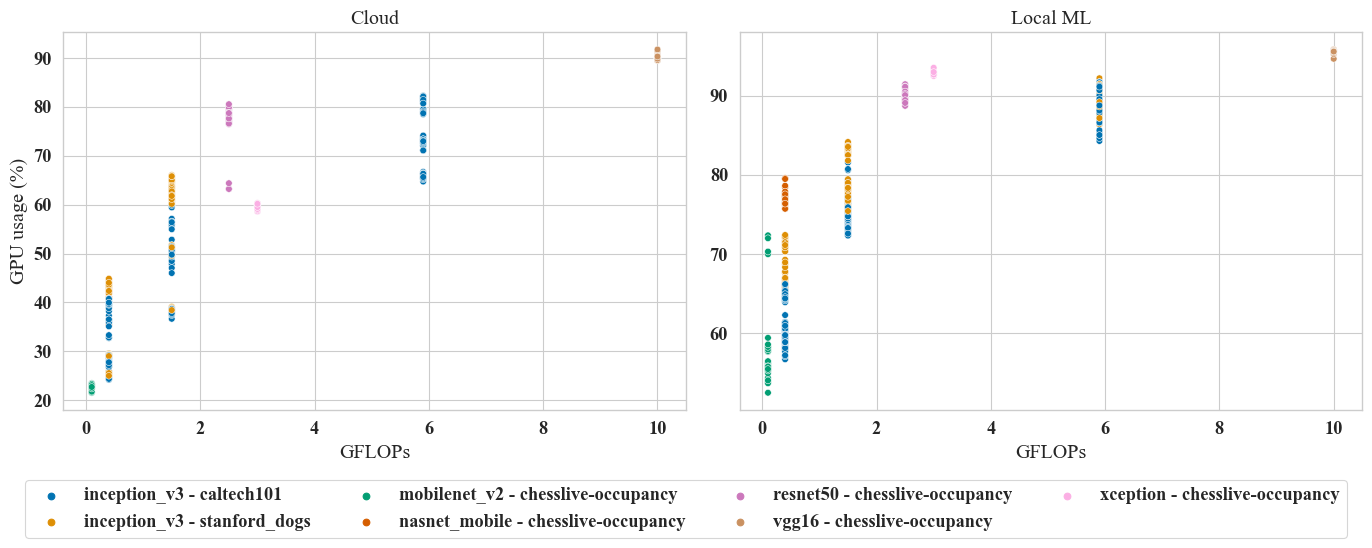

In [50]:
fig = plt.figure(figsize=(14, 5))

ax = plt.subplot(121)
cloud_data = tmp.query("`training environment` == 'Cloud'")
cloud_data.loc[:, "GFLOPs"] = cloud_data["GFLOPs"].round(1)

sns.scatterplot(
    data=cloud_data,
    x="GFLOPs",
    y="gpu usage (%)",
    hue="label",
    hue_order=sorted(tmp["label"].unique()),
    palette="colorblind",
    ax=ax,
)
ax.set_xlabel("GFLOPs")
ax.set_ylabel("GPU usage (%)")
ax.set_title("Cloud")
ax.legend_.remove()

# df = cloud_data.query("`architecture` != 'inception_v3'")
# x = df["GFLOPs"]
# y = df["gpu usage (%)"]
# p = np.polynomial.Polynomial.fit(x, y, 1)
# xx, yy = p.linspace()
# ax.plot(xx, yy, linestyle="--", color="gray", alpha=0.7)

# cloud_inception = cloud_data.query("`architecture` == 'inception_v3'")
# for row in cloud_inception[["dataset", "batch size"]].drop_duplicates().itertuples():
#     df = cloud_inception.query("`dataset` == @row[1] and `batch size` == @row[2]")
#     x = df["GFLOPs"]
#     y = df["gpu usage (%)"]

#     p = np.polynomial.Polynomial.fit(x, y, 1)
#     xx, yy = p.linspace()
#     ax.plot(xx, yy, linestyle="--", color="gray", alpha=0.7)


ax = plt.subplot(122)
local_ml_data = tmp.query("`training environment` == 'Local ML'")
local_ml_data.loc[:, "GFLOPs"] = local_ml_data["GFLOPs"].round(1)

sns.scatterplot(
    data=local_ml_data,
    x="GFLOPs",
    y="gpu usage (%)",
    hue="label",
    hue_order=sorted(tmp["label"].unique()),
    palette="colorblind",
    ax=ax,
)
ax.set_xlabel("GFLOPs")
ax.set_ylabel("")
ax.set_title("Local ML")

# df = local_ml_data.query("`architecture` != 'inception_v3'")
# x = df["GFLOPs"]
# y = df["gpu usage (%)"]

# p = np.polynomial.Polynomial.fit(x, y, 1)
# xx, yy = p.linspace()
# ax.plot(xx, yy, linestyle="--", color="gray", alpha=0.7, label="tendency line")


# local_inception = local_ml_data.query("`architecture` == 'inception_v3'")
# for row in local_inception[["dataset", "batch size"]].drop_duplicates().itertuples():
#     df = local_inception.query("`dataset` == @row[1] and `batch size` == @row[2]")
#     x = df["GFLOPs"]
#     y = df["gpu usage (%)"]

#     p = np.polynomial.Polynomial.fit(x, y, 1)
#     xx, yy = p.linspace()
#     ax.plot(xx, yy, linestyle="--", color="gray", alpha=0.7)

handles, labels = ax.get_legend_handles_labels()
ax.legend_.remove()
fig.legend(handles=handles, labels=labels, loc="upper center", bbox_to_anchor=(0.5, 0.03), ncol=4)

if SAVE_FIGS:
    plt.savefig(SAVE_FIGS_DIR / f"energy-vs-flops.{FIGURES_FORMAT}", format=FIGURES_FORMAT)

#### Is there a correlation between GPU utilization and power consumption?


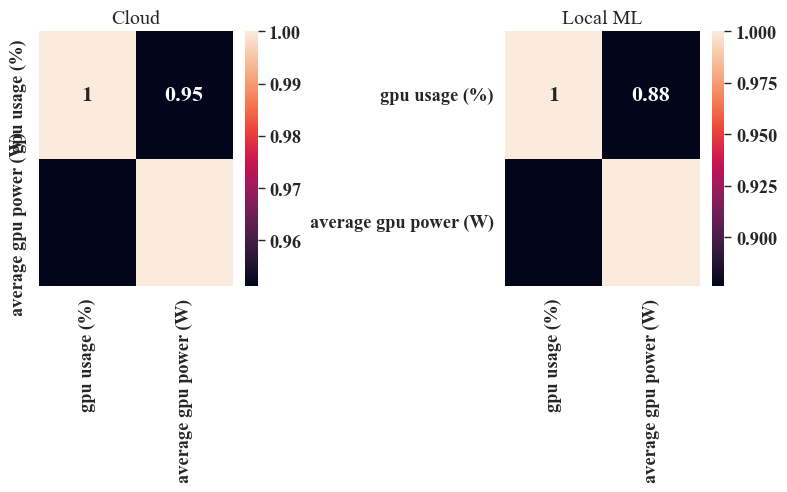

In [51]:
plt.figure(figsize=(8, 8))

correlation = cloud_data.loc[:, ["gpu usage (%)", "average gpu power (W)"]].corr()
# Plot correlation matrix
ax = plt.subplot(223)
sns.heatmap(correlation, annot=True, ax=ax)
ax.set_title("Cloud")
ax.set_xlabel("")
ax.set_ylabel("")
plt.tight_layout()

correlation = local_ml_data.loc[:, ["gpu usage (%)", "average gpu power (W)"]].corr()
# Plot correlation matrix
ax = plt.subplot(224)
sns.heatmap(correlation, annot=True, ax=ax)
ax.set_title("Local ML")
ax.set_xlabel("")
ax.set_ylabel("")
plt.tight_layout()